## init Keras

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [ ]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import seaborn as sns
from scipy.io import loadmat
from scipy.io import savemat
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import os
import pandas as pd

reparameterization trick<br>
instead of sampling from Q(z|X), sample epsilon = N(0,I)<br>
z = z_mean + sqrt(var) * epsilon

### Some helper Funcs

In [3]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
import numpy as np

def calculate_distance_along_line(starting_point, end_point, data_points):
    # Step 1: Calculate line vector
    line_vector = end_point - starting_point
    # Step 2: Normalize line vector
    line_direction = line_vector / np.linalg.norm(line_vector)

    distances = []
    for point in data_points:
        # Step 3: Calculate displacement vector
        displacement_vector = point - starting_point
        # Step 4: Project displacement vector onto line direction
        distance_along_line = np.dot(displacement_vector, line_direction)
        distances.append(distance_along_line)
    #distances

    #return np.array(list(filter(lambda d: d>0,np.diff(distances))))  # If i only want the advancement 
    return np.diff(distances)


In [46]:

def calc_cohensd(x,y):
    d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
    print(f"Cohens d =:{d}")
    return d

# Define exp variables

In [5]:
EXP_NAME = 'gusDMF_G159-175_CondVae'
ONLY_UWSMCS = False
WITH_PERTURB = False

## Load Data

In [9]:
#Change to repository directory
results_path = "/home/ivan.mindlin/Repos/pharmacological-perturbations/Results/"

In [11]:
NUM_SIM = 3000
CNT_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    CNT_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(results_path+f"FCGeneration/G210_CNT/CNT_G210_{rep}.mat")["FC_simul2"],(20,8100))
MCS_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    MCS_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(results_path+f"FCGeneration/G175_MCS/MCS_G175_{rep}.mat")["FC_simul2"],(20,8100))
UWS_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    UWS_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(results_path+f"FCGeneration/G159_UWS/UWS_G159_{rep}.mat")["FC_simul2"],(20,8100))



In [12]:


if WITH_PERTURB:
    conditions = ['5HT2A', '5HT1A','D2', 'D1', 'H3', 'MU','DAT']
    UWSMCS_perturbs = np.zeros((len(conditions)*2,20, 101, 8100))
    for idx,cond in enumerate(conditions):
        perturb_fcs = loadmat(results_path+f"FC_{cond}_MCS.mat")["FC_simul_all"]
        UWSMCS_perturbs[idx, :,:, : ] = np.reshape(perturb_fcs, (20,101, 8100))
    conditions = ['5HT2A', '5HT1A','D2', 'D1', 'H3', 'MU','DAT']
    for idx,cond in enumerate(conditions):
        perturb_fcs = loadmat(results_path+f"FC_{cond}_UWS.mat")["FC_simul_all"]
        UWSMCS_perturbs[idx+len(conditions), :,:, : ] = np.reshape(perturb_fcs, (20,101, 8100))
    UWSMCS_perturbs = np.reshape(UWSMCS_perturbs, (UWSMCS_perturbs.shape[0]*UWSMCS_perturbs.shape[1]*UWSMCS_perturbs.shape[2], 8100))
    small_data = np.concatenate((CNT_data,UWS_data,MCS_data, UWSMCS_perturbs),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,)),np.ones((NUM_SIM,))*2,np.ones((UWSMCS_perturbs.shape[0],))*3),axis=0)
elif ONLY_UWSMCS: 
    small_data = np.concatenate((CNT_data,UWS_data),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,))),axis=0)
else: # Classic with all
    small_data = np.concatenate((CNT_data,UWS_data,MCS_data),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,)),np.ones((NUM_SIM,))*2),axis=0)
if not os.path.exists(f"models/{EXP_NAME}_idx.npy"):
    print("Generating random indexation")
    with open(f"models/{EXP_NAME}_idx.npy", 'wb') as f:
        print("Creating data index")
        idx = np.random.permutation(small_data.shape[0])
        np.save(f,idx)
else:
    print("Loading random indexation")
    with open(f"models/{EXP_NAME}_idx.npy", 'rb') as f:
        idx = np.load(f)
my_data, label_1 = small_data[idx,:],label[idx]
x_train = my_data[:int(len(my_data) * 0.6)]  # 60% for training
x_val = my_data[int(len(my_data) * 0.6):int(len(my_data) * 0.8)]  # 20% for validation
x_test = my_data[int(len(my_data) * 0.8):]  # 20% for testing

y_train = label_1[:int(len(my_data) * 0.6)]
y_val = label_1[int(len(my_data) * 0.6):int(len(my_data) * 0.8)]
y_test = label_1[int(len(my_data) * 0.8):]

Loading random indexation


## Create or Load model

In [ ]:
from keras.layers import Dropout
from keras.layers.merge import concatenate as concat
from keras.losses import mean_squared_error
model_name = EXP_NAME
experiment_name = EXP_NAME
original_dim = 8100 
intermediate_dim = 128
batch_size = 256
latent_dim = 3
epochs = 50
# Creating a conditional VAE we need to add the label in the input
input_shape = (original_dim, )
intput_label_shape = 1#y_train.shape[1]
inputs_x = Input(shape=input_shape, name='x_input')
inputs_label = Input(shape=(1,),name='label_input')
inputs = concat([inputs_x, inputs_label],axis=1)

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,inputs_label], [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

latent_x = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs = concat([latent_x, inputs_label])

x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(0.2)(x)
outputs = Dense(original_dim+1, activation='sigmoid')(x)
decoder = Model([latent_x, inputs_label], outputs, name='decoder')
#decoder.summary()

#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

outputs = decoder([encoder([inputs_x, inputs_label])[2], inputs_label])
vae = Model([inputs_x,inputs_label], outputs, name=model_name)
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inputs,outputs)
#reconstruction_loss = mean_squared_error(inputs,outputs)

                                                
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

### Loading or training

In [ ]:
TRAIN = False
if TRAIN:
        vae.fit([x_train,y_train],
                epochs=epochs,
                batch_size=batch_size,
                validation_data=([x_test,y_test], None))
             
        vae.save_weights(f"models/{experiment_name}" + '.h5')
        
        # serialize model to JSON
        model_json = vae.to_json()
        with open(f"models/{experiment_name}"+".json", "w") as json_file:
                json_file.write(model_json)
else:
        print("Loading trained model")
        from keras.models import model_from_json
        model_name = EXP_NAME
        experiment_name = EXP_NAME
        with open(f"models/{experiment_name}.json",'r') as f:
                model_json = f.read()
        vae = model_from_json(model_json.encode())
        vae.load_weights(f"models/{experiment_name}.h5") 
        

# FIG 2 plots

## Stat diff between genererated FC


In [18]:
# For consistency SSIM was caclulated on MATLAB
df = pd.read_csv(results_path+'ALL_sim_vs_emp_comp.txt', sep=',',names=['simulation', 'SSIM', 'empirical'])

In [19]:
from scipy.stats import kruskal
cohensd = []
p_values_fig2 = []
stats_fig2 = []
x = df[(df['simulation']=='UWS') & (df['empirical']=='MCS')]['SSIM']
y = df[(df['simulation']=='UWS') & (df['empirical']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS simulation vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='UWS') & (df['empirical']=='UWS')]['SSIM']
y = df[(df['simulation']=='UWS') & (df['empirical']=='MCS')]['SSIM']
print(f"SSIM for UWS: {np.mean(x)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS simulation vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='UWS') & (df['empirical']=='UWS')]['SSIM']
y = df[(df['simulation']=='UWS') & (df['empirical']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS simulation vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")

print("\n")

x = df[(df['simulation']=='MCS') & (df['empirical']=='MCS')]['SSIM']
y = df[(df['simulation']=='MCS') & (df['empirical']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS simulation vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='MCS') & (df['empirical']=='UWS')]['SSIM']
y = df[(df['simulation']=='MCS') & (df['empirical']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS simulation vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='MCS') & (df['empirical']=='MCS')]['SSIM']
y = df[(df['simulation']=='MCS') & (df['empirical']=='UWS')]['SSIM']
print(f"SSIM for MCS: {np.mean(x)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS simulation vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


print("\n")

x = df[(df['simulation']=='CNT') & (df['empirical']=='MCS')]['SSIM']
y = df[(df['simulation']=='CNT') & (df['empirical']=='UWS')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT simulation vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='CNT') & (df['empirical']=='MCS')]['SSIM']
y = df[(df['simulation']=='CNT') & (df['empirical']=='CNT')]['SSIM']
print(f"SSIM for CNT: {np.mean(y)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT simulation vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['simulation']=='CNT') & (df['empirical']=='UWS')]['SSIM']
y = df[(df['simulation']=='CNT') & (df['empirical']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT simulation vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")



UWS simulation vs CNT and MCS
 K=224.25 P=1.068595804969942e-50 Cohens d =:23.457616659018736
SSIM for UWS: 0.38701142000000005
UWS simulation vs MCS and UWS
 K=224.25 P=1.0686492946266521e-50 Cohens d =:8.75708845674425
UWS simulation vs CNT and UWS
 K=224.25 P=1.0686225494695619e-50 Cohens d =:31.969865912840806


MCS simulation vs CNT and MCS
 K=224.25 P=1.0686225494695619e-50 Cohens d =:17.24811996921288
MCS simulation vs CNT and UWS
 K=224.25 P=1.0686492946266521e-50 Cohens d =:22.605145776283816
SSIM for MCS: 0.34776904666666664
MCS simulation vs MCS and UWS
 K=224.25 P=1.0686492946266521e-50 Cohens d =:-5.392327170202127


CNT simulation vs MCS and UWS
 K=34.04 P=5.402152815147594e-09 Cohens d =:-0.6822891290264215
SSIM for CNT: 0.27267494
CNT simulation vs CNT and MCS
 K=224.25 P=1.0686492946266521e-50 Cohens d =:7.20922536820825
CNT simulation vs CNT and UWS
 K=224.25 P=1.0686492946266521e-50 Cohens d =:6.87647708318417


In [21]:
plots_path = "/home/ivan.mindlin/Repos/pharmacological-perturbations/plots/"

In [ ]:
from statannot import add_stat_annotation
# Define the scaling factor
scaling_factor = 2

# Apply the scaling factor to the original figure size and font size
fig_width = 5 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

sns.set_theme(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
# define the custom color palette


baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
#baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
bxplt = sns.boxplot(df, x='simulation', y='SSIM', hue='empirical', ax=ax,palette=baseline_colors)
ax.axhline(np.mean(df[(df['simulation']=='CNT') & (df['empirical']=='CNT')]['SSIM']), linestyle='dashed',color=baseline_colors[2])
ax.axhline(np.mean(df[(df['simulation']=='UWS') & (df['empirical']=='UWS')]['SSIM']), linestyle='dashed',color=baseline_colors[0])
ax.axhline(np.mean(df[(df['simulation']=='MCS') & (df['empirical']=='MCS')]['SSIM']), linestyle='dashed',color=baseline_colors[1])

plt.title(f"Empiricals vs Optimal G")
plt.ylabel("SSIM")
plt.xlabel("Optimal G condition")
plt.savefig(f"plots/Figure2/StatDifferenceBetweenModels.svg", bbox_inches='tight')
plt.savefig(f"plots/Figure2/StatDifferenceBetweenModels.png", bbox_inches='tight')
plt.show()


In [121]:
np.mean(df[(df['simulation']=='UWS') & (df['empirical']=='UWS')]['SSIM'])

0.38701142000000005

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway
from scipy.stats import kruskal
# Generate sample data
n = 251
repetitions = 15
scaling = np.linspace(0, 2.5, n)
MCS_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/MCS_Stat_results_15")['FittSSIM_all_mcs']
CNT_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/CNT_Stat_results_15")['FittSSIM_all_cnt']
UWS_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/UWS_Stat_results_15")['FittSSIM_all_uws']

data = []

for rep in range(UWS_fit.shape[0]):
    for i in range(UWS_fit.shape[1]):
        data.append(['UWS', UWS_fit[rep, i], scaling[i], rep + 1])

for rep in range(MCS_fit.shape[0]):
    for i in range(MCS_fit.shape[1]):
        data.append(['MCS', MCS_fit[rep, i], scaling[i], rep + 1])

for rep in range(CNT_fit.shape[0]):
    for i in range(CNT_fit.shape[1]):
        data.append(['CNT', CNT_fit[rep, i], scaling[i], rep + 1])

df = pd.DataFrame(data, columns=['condition', 'SSIM', 'scaling', 'rep'])

optimal_values = df.groupby(['condition', 'rep'])['SSIM'].idxmax()
optimal_df = df.loc[optimal_values]



### Curves

In [26]:
optimal_df.groupby('condition')['SSIM'].mean()

condition
CNT    0.282906
MCS    0.357491
UWS    0.396416
Name: SSIM, dtype: float64

In [27]:
optimal_df.groupby('condition')['scaling'].std()

condition
CNT    0.046414
MCS    0.073062
UWS    0.065625
Name: scaling, dtype: float64

In [28]:
optimal_df.groupby('condition')['scaling'].mean()

condition
CNT    2.094000
MCS    1.753333
UWS    1.589333
Name: scaling, dtype: float64

In [ ]:

# Define the scaling factor
scaling_factor = 1.5
fig_width = 7 * scaling_factor
fig_height = 5 * scaling_factor
font_size = 16 * scaling_factor

#sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
baseline_cmap_cond2num = {'CNT': 2, 'UWS': 0, 'MCS': 1}
palette = sns.color_palette("viridis", n_colors=101)

hue_values = np.array(['UWS', 'MCS', 'CNT'])#df["condition"].unique()
baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

n = 251
repetitions = 15
scaling = np.linspace(0, 2.5, n)
MCS_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/MCS_Stat_results_15")['FittSSIM_all_mcs']
CNT_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/CNT_Stat_results_15")['FittSSIM_all_cnt']
UWS_fit = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/UWS_Stat_results_15")['FittSSIM_all_uws']

data = []

for rep in range(UWS_fit.shape[0]):
    for i in range(UWS_fit.shape[1]):
        data.append(['UWS', UWS_fit[rep, i], scaling[i], rep + 1])

for rep in range(MCS_fit.shape[0]):
    for i in range(MCS_fit.shape[1]):
        data.append(['MCS', MCS_fit[rep, i], scaling[i], rep + 1])

for rep in range(CNT_fit.shape[0]):
    for i in range(CNT_fit.shape[1]):
        data.append(['CNT', CNT_fit[rep, i], scaling[i], rep + 1])

df = pd.DataFrame(data, columns=['condition', 'SSIM', 'scaling', 'rep'])
sns.lineplot(data=df, x="scaling", y="SSIM", hue="condition", palette=baseline_colors,err_style="bars", errorbar=("se", 2))
mean_lines = optimal_df.groupby('condition')['scaling'].mean()
for idx, hue in enumerate(hue_values):    
    mean_value = mean_lines[hue]    
    line_color = baseline_colors[idx]#baseline_colors[idx]#sns.color_palette()[hue_values.tolist().index(hue)]
    ax.axvline(x=mean_value, color=line_color, linestyle="--")
    print(mean_value)
    
ax.legend(labels=["UWS", "MCS", "CNT"])
legend = ax.get_legend()
legend.set_title("")
ax.set_title("Baseline models fitting")
ax.set_xlabel("G")
ax.set_ylabel("SSIM")
plt.xticks()
plt.yticks()
plt.savefig(f"plots/Figure2/FittingCurves.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure2/FittingCurves.png", bbox_inches='tight')
plt.show()


# Fig 3 

### Baseline Projections

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme()

models = vae.get_layer('encoder'),vae.get_layer('decoder')
baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]]) # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot


plt.figure(figsize=(14, 11))
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65)

BETA = np.arange(0,1.01,0.01)

plt.xlabel("Z$_0$",fontsize=28)
plt.ylabel("Z$_1$",fontsize=28)
legend = plt.legend(fontsize=30)
for lh in legend.legendHandles:
    lh._sizes = [200]  # Adjust the marker size as needed

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Latent representation of baseline FC", fontsize=30)
plt.savefig(f"plots/Figure3/BaselineCentroids.svg", dpi=600, bbox_inches='tight')
plt.savefig(f"plots/Figure3/BaselineCentroids.png", dpi=600, bbox_inches='tight')
plt.show()



In [31]:
# Use a simple SVM classifier to classifylatent the latent space
# Import the libraries
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Split the data from latent_clusters variables. In latetnt_clusters[0] we have UWS, in [1] MCS and in [2] CNT
Xlatent = np.concatenate(latetnt_clusters)
ylatent = np.concatenate([np.ones(latetnt_clusters[0].shape[0])*1,np.ones(latetnt_clusters[1].shape[0])*2,np.ones(latetnt_clusters[2].shape[0])*0])
# Split the data
Xlatent_train, Xlatent_test, ylatent_train, ylatent_test = train_test_split(Xlatent, ylatent, test_size=0.2, random_state=42)
# Create the model
clf = SVC()
# Fit the model
clf.fit(Xlatent_train, ylatent_train)
# Predict the test data
ylatent_pred = clf.predict(Xlatent_test)
# Calculate the accuracylatent
accuracylatent = accuracy_score(ylatent_test, ylatent_pred)
print("Accuracylatent: ", accuracylatent)
# Print the classification report
print(classification_report(ylatent_test, ylatent_pred))



Accuracylatent:  0.9555555555555556
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       127
         1.0       0.95      0.94      0.94       128
         2.0       0.92      0.93      0.92       105

    accuracy                           0.96       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.96      0.96      0.96       360



In [32]:
# Store the classification report in a DataFrame to have a better display
# Extract the classification report
report = classification_report(ylatent_test, ylatent_pred, output_dict=True)
# Create a DataFrame
df_report = pd.DataFrame(report).transpose()

In [33]:
df_report.head()

precision    recall  f1-score     support
0.0         0.992126  0.992126  0.992126  127.000000
1.0         0.952381  0.937500  0.944882  128.000000
2.0         0.915888  0.933333  0.924528  105.000000
accuracy    0.955556  0.955556  0.955556    0.955556
macro avg   0.953465  0.954320  0.953845  360.000000

In [ ]:
import pandas as pd
import numpy as np


scaling_factor = 2
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

uws_distances = np.linalg.norm(latetnt_clusters[0] - cnt_centroid, axis=1)
mcs_distances = np.linalg.norm(latetnt_clusters[1] - cnt_centroid, axis=1)

data = pd.DataFrame({
    'Distance': np.concatenate([uws_distances, mcs_distances]),
    'Cond': ['UWS'] * len(uws_distances) + ['MCS'] * len(mcs_distances)
})


fig, ax = plt.subplots(figsize=(fig_width, fig_height+0.7)) 
vlplt = sns.violinplot(data,x='Cond', y='Distance',palette=baseline_colors, showmedians=True, widths=0.7, showextrema=False)


calc_cohensd(data[data['Cond']=='UWS']['Distance'],data[data['Cond']=='MCS']['Distance'])
   
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(baseline_colors[i])
plt.xticks([0, 1], ['UWS','MCS'], fontsize=font_size)
plt.xlabel('')

plt.ylabel('Distances', fontsize=font_size)
plt.title('Distance to control centroid', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure3/Distance2CNTCentroid.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure3/Distance2CNTCentroid.png", bbox_inches='tight')
plt.show()

## Grid FC sampling

In [35]:
XLIM = (-5, 1)
YLIM = (-2,2)

## Modularity and integration analysis

In [ ]:
import numpy as np
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
from scipy import stats

SC = stats.zscore(loadmat(os.path.join("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/","ts_coma24_AAL_symm_withSC.mat"))['SC'])
sc_matrix_binary = np.where(SC>0, 1, 0)
triu_idx = np.triu_indices(SC.shape[1],1)


import numpy as np
from skimage import measure
def k_percent_threshold(matrix, k):
    max_val = np.max(matrix)
    threshold = k / 100.0 * max_val
    binary_matrix = np.where(matrix >= threshold, 1, 0)
    return binary_matrix

import numpy as np
from collections import Counter

def bin_vector(vector, num_bins):
    """
    Bin a vector into a specified number of bins.

    Parameters:
    vector (array-like): Input vector.
    num_bins (int): Number of bins to create.

    Returns:
    ndarray: Binned vector.
    """
    min_val = min(vector)
    max_val = max(vector)
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    binned_vector = np.digitize(vector, bin_edges)
    return binned_vector

def shannon_entropy(vector):
    """
    Calculate Shannon entropy of a vector.

    Parameters:
    vector (array-like): Input vector.

    Returns:
    float: Shannon entropy.
    """
    counter = Counter(vector)
    total_count = len(vector)
    probabilities = [count / total_count for count in counter.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy



def get_fractal_dimension(fc_matrix):
    threshold = np.mean(fc_matrix)
    binary_fc_matrix = k_percent_threshold(fc_matrix,50)


    box_counts = []
    box_sizes = []

    for box_size in range(1, min(binary_fc_matrix.shape)//2):

        boxes_per_row = binary_fc_matrix.shape[0] // box_size
        boxes_per_col = binary_fc_matrix.shape[1] // box_size
        occupied_boxes = np.sum(binary_fc_matrix[:boxes_per_row*box_size, :boxes_per_col*box_size].reshape(boxes_per_row, box_size, boxes_per_col, box_size), axis=(1, 3)) > 0
        box_counts.append(np.sum(occupied_boxes))
        box_sizes.append(box_size)

    coeffs = np.polyfit(np.log(box_sizes), np.log(box_counts), 1)
    fractal_dimension = -coeffs[0]
    return fractal_dimension

def mod_int_and_corr(FC):
    G = nx.from_numpy_array(FC)
    corr = stats.pearsonr(FC[triu_idx[0],triu_idx[1]], SC[triu_idx[0],triu_idx[1]])[0]
    threshold = 0.1
    edges_to_remove = []
    for u, v, d in G.edges(data=True):
        if d["weight"] < threshold:
            edges_to_remove.append((u, v))

    for u, v in edges_to_remove:
        G.remove_edge(u, v)
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    binarized_fc = k_percent_threshold(FC,50)
    frac_dim = get_fractal_dimension(binarized_fc)
    #lzcomplexity = LZ76(binarized_fc)/810
    entropy = shannon_entropy(bin_vector(FC.flatten(), 30))
    mean_str_entropy = shannon_entropy(bin_vector(FC.mean(axis=0), 30))

    #if not nx.is_connected(G):
    #    largest_cc = max(nx.connected_components(G), key=len)
    #    G = G.subgraph(largest_cc).copy()
    #
    #try:
    #    avg_shortest_path_length = nx.average_shortest_path_length(G)
    #except nx.NetworkXError:
    #    print("Graph is not connected, cannot compute average shortest path length.")
    mean_fc = np.mean(np.mean(FC)) # Reviewrs ask to replace avg short path length
    return modularity,mean_fc,corr,frac_dim, entropy, mean_str_entropy


In [37]:

#
grid_x_range = (XLIM[0], XLIM[1])
grid_x_size = 32
grid_y_range = (YLIM[0], YLIM[1])
grid_y_size = 16


grid_x = np.linspace(grid_x_range[0], grid_x_range[1], grid_x_size)
grid_y = np.linspace(grid_y_range[0], grid_y_range[1], grid_y_size)[::-1]
digit_size = 90

total_size_x = digit_size * grid_x_size
total_size_y = digit_size * grid_y_size


figure_mod = np.zeros((total_size_y, total_size_x))
figure_mean = np.zeros((total_size_y, total_size_x))
figure_corr = np.zeros((total_size_y, total_size_x))
figure_ent = np.zeros((total_size_y, total_size_x))
figure_frac_dim = np.zeros((total_size_y, total_size_x))



mod_min = np.inf  
mod_max = -np.inf  
int_min = np.inf  
int_max = -np.inf  
RECORD = False
if RECORD:
    print("Running everything again")
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.hstack((xi, yi)).reshape(1, 2)
            label_input = np.array([yi]).reshape(1,1)
            x_decoded = decoder.predict([z_sample,label_input])
            fc_matrix = x_decoded[0][:8100].reshape(digit_size, digit_size)

            modularity, mean_fc, corr, frac_dim, entropy, str_entropy = mod_int_and_corr(fc_matrix)

            # Calculate the indices for the current region
            start_row = i * digit_size
            end_row = (i + 1) * digit_size
            start_col = j * digit_size
            end_col = (j + 1) * digit_size

            figure_mod[start_row:end_row, start_col:end_col] = modularity
            figure_mean[start_row:end_row, start_col:end_col] = mean_fc
            figure_corr[start_row:end_row, start_col:end_col] = corr
            figure_ent[start_row:end_row, start_col:end_col] = entropy
            figure_frac_dim[start_row:end_row, start_col:end_col] = frac_dim

            # Update minimum and maximum values
            mod_min = min(mod_min, modularity)
            mod_max = max(mod_max, modularity)
            int_min = min(int_min, mean_fc)
            int_max = max(int_max, mean_fc)

    with open(f"models/{EXP_NAME}ent.npy", 'wb') as f:
        np.save(f,figure_ent)

    with open(f"models/{EXP_NAME}mod.npy", 'wb') as f:
        np.save(f,figure_mod)

    with open(f"models/{EXP_NAME}mean.npy", 'wb') as f:
        np.save(f,figure_mean)

    with open(f"models/{EXP_NAME}corr.npy", 'wb') as f:
        np.save(f,figure_corr)

    with open(f"models/{EXP_NAME}frac_dim.npy", 'wb') as f:
        np.save(f,figure_frac_dim)
else:
    print("Loading previous grid analysis")
    with open(f"models/{EXP_NAME}ent.npy", 'rb') as f:
        figure_ent = np.load(f)

    with open(f"models/{EXP_NAME}mod.npy", 'rb') as f:
        figure_mod = np.load(f)

    with open(f"models/{EXP_NAME}mean.npy", 'rb') as f:
        figure_mean = np.load(f)

    with open(f"models/{EXP_NAME}corr.npy", 'rb') as f:
        figure_corr = np.load(f)

    with open(f"models/{EXP_NAME}frac_dim.npy", 'rb') as f:
        figure_frac_dim = np.load(f)


Loading previous grid analysis


## Grids of metrics

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


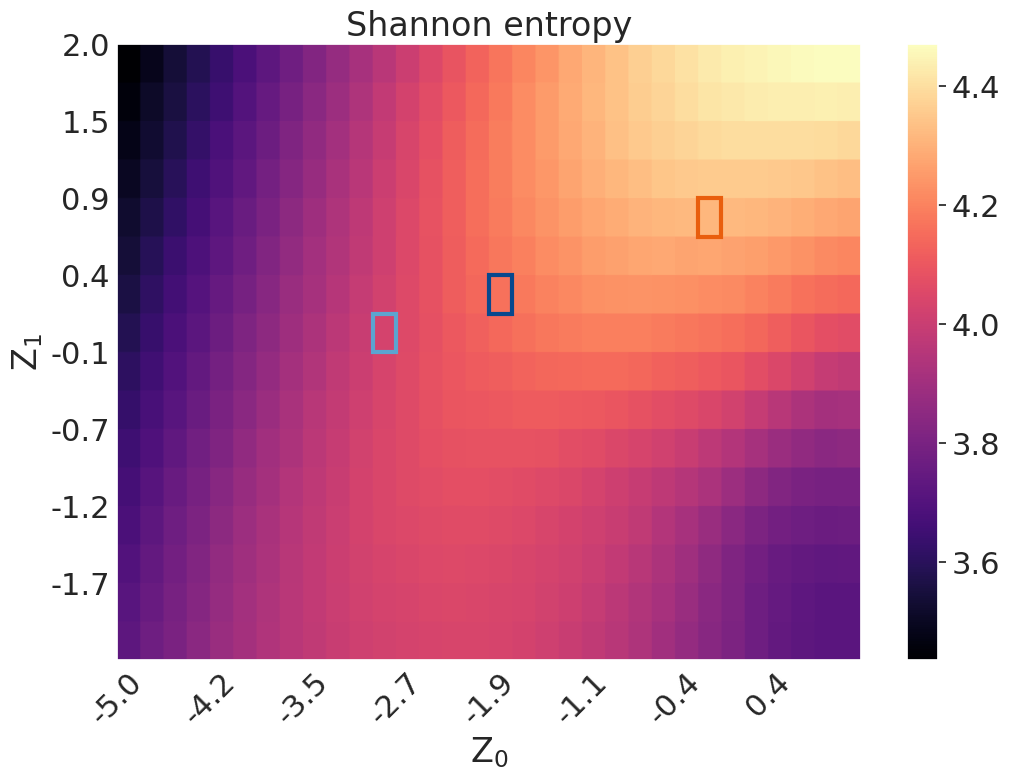

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


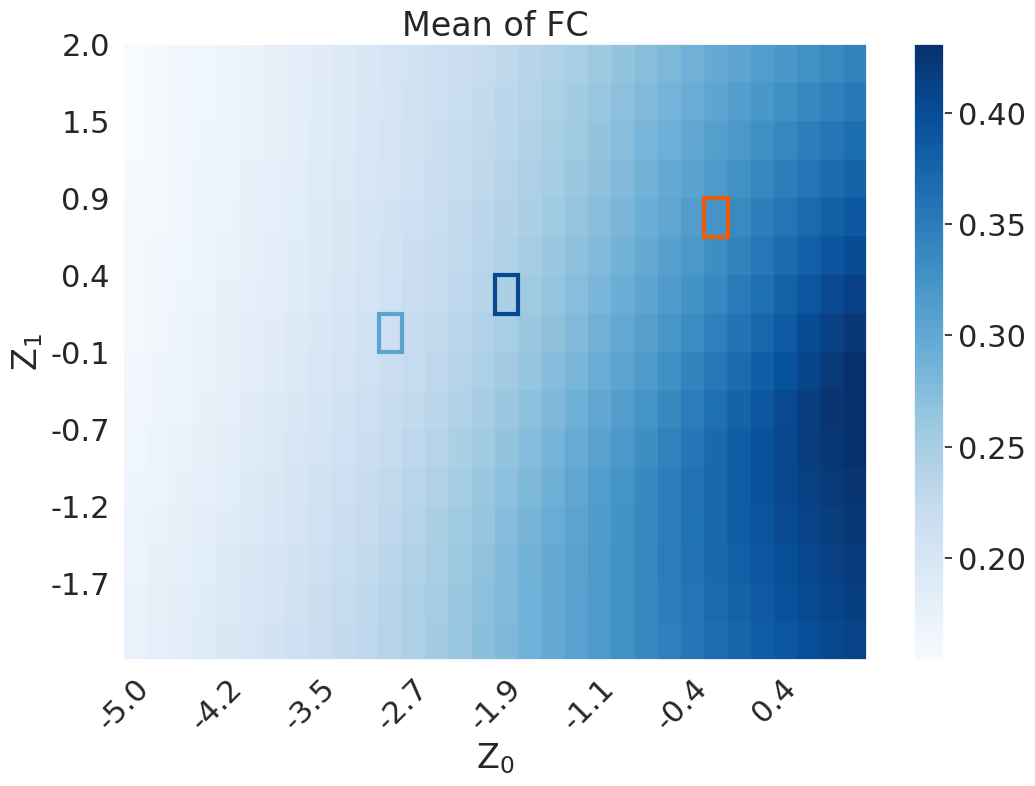

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:110: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


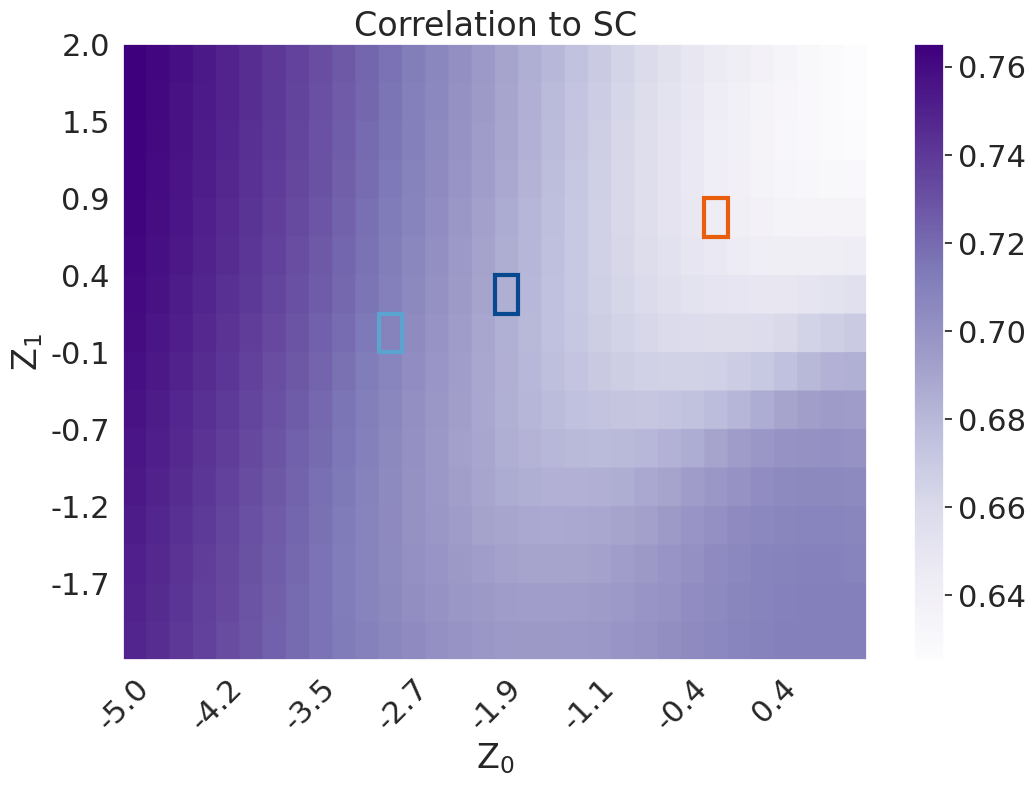

In [38]:
import matplotlib.pyplot as plt

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor


uws_row = 7
uws_col = 11
uws_start_row = uws_row * digit_size
uws_end_row = (uws_row + 1) * digit_size
uws_start_col = uws_col * digit_size
uws_end_col = (uws_col + 1) * digit_size
mcs_row = 6
mcs_col = 16
mcs_start_row = mcs_row * digit_size
mcs_end_row = (mcs_row + 1) * digit_size
mcs_start_col = mcs_col * digit_size
mcs_end_col = (mcs_col + 1) * digit_size
cnt_row = 4
cnt_col = 25
cnt_start_row = cnt_row * digit_size
cnt_end_row = (cnt_row + 1) * digit_size
cnt_start_col = cnt_col * digit_size
cnt_end_col = (cnt_col + 1) * digit_size


# Plot 
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_ent, cmap='magma', vmin=np.min(figure_ent), vmax=np.max(figure_ent), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  # Add colorbar
#cbar.ax.tick_params()

# Add border color to the highlighted region

plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0], linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1], linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2], linewidth=3))

x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)

# Only show every second tick label
x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]

plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)


# Show only half of the x-axis tick labels
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    cur_ticl = np.round(grid_x, 1)[i]    
    if i % 2 != 0:
        tick.set_visible(False)

# Show only half of the y-axis tick labels
for i, tick in enumerate(plt.gca().yaxis.get_major_ticks()):
    if i % 2 != 0:
        tick.set_visible(False)

plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")

# Adjust tick parameters
plt.tick_params(axis='both', which='both', length=0, pad=5)

plt.grid(color='w', linewidth=2)
plt.title("Shannon entropy")
plt.savefig(f"plots/Figure3/entropy.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/entropy.png",bbox_inches = 'tight')
plt.show()


# Plot mean_fc
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_mean, cmap='Blues', vmin=np.min(figure_mean), vmax=np.max(figure_mean), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  # Add colorbar
#cbar.ax.tick_params()
x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)

x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]

plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2] , linewidth=3))
plt.grid(color='w', linewidth=2)
plt.title("Mean of FC")
plt.savefig(f"plots/Figure3/mean_fc.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/mean_fc.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_corr, cmap='Purples', vmin=np.min(figure_corr), vmax=np.max(figure_corr), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  # Add colorbar
x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)

x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]

plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)

plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2] , linewidth=3))
plt.title("Correlation to SC")
plt.grid(color='w', linewidth=2)
plt.savefig(f"plots/Figure3/corr2SC.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/corr2SC.png",bbox_inches = 'tight')
plt.show()


## Metrics distribution in set of projected baseline points

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize empty lists to store metric values for each condition
modularity_values = {'CNT': [], 'UWS': [], 'MCS': []}
mean_fc_values = {'CNT': [], 'UWS': [], 'MCS': []}
corr_values = {'CNT': [], 'UWS': [], 'MCS': []}
entropy_values = {'CNT': [], 'UWS': [], 'MCS': []}
frac_dim_values = {'CNT': [], 'UWS': [], 'MCS': []}

baseline_cmap = {0: 'UWS', 1: 'MCS',2: 'CNT'}
baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
RECORD = False
if RECORD:
    for idx, cluster_points in enumerate(latetnt_clusters):
        unique_points = np.unique(cluster_points,axis=0)
        for x,y in unique_points:     
            z_sample = np.hstack((x, y)).reshape(1, 2)#np.array([xi, yi])
            label_input = np.array([y]).reshape(1,1)
            x_decoded = decoder.predict([z_sample,label_input])
            fc_matrix = x_decoded[0][:8100].reshape(digit_size, digit_size)
            modularity, mean_fc, corr, frac_dim, entropy, str_entropy = mod_int_and_corr(fc_matrix)
            
            # Determine the condition based on idx
            condition = baseline_cmap[idx]
            
            # Append metric values to the respective lists for the condition
            modularity_values[condition].append(modularity)
            mean_fc_values[condition].append(mean_fc)
            corr_values[condition].append(corr)
            entropy_values[condition].append(entropy)
            frac_dim_values[condition].append(frac_dim)

    # Convert metric values to a pandas DataFrame
    metrics_data = pd.DataFrame({
        'Modularity': modularity_values['UWS'] + modularity_values['MCS'] + modularity_values['CNT'],
        'Mean FC': mean_fc_values['UWS'] + mean_fc_values['MCS'] + mean_fc_values['CNT'],
        'Correlation': corr_values['UWS'] + corr_values['MCS'] + corr_values['CNT'],
        'Entropy': entropy_values['UWS'] + entropy_values['MCS'] + entropy_values['CNT'],
        'Fractal Dimension': frac_dim_values['UWS'] + frac_dim_values['MCS'] + frac_dim_values['CNT'],
        'Condition': ['UWS'] * len(modularity_values['UWS']) + ['MCS'] * len(modularity_values['MCS']) + ['CNT'] * len(modularity_values['CNT'])
    })

    metrics_data.to_pickle(f"models/{EXP_NAME}metrics_ent.pkl")


else:
    print("Loading previous grid analysis")
    metrics_data = pd.read_pickle(f"models/{EXP_NAME}metrics_ent.pkl")




Loading previous grid analysis


In [41]:
print("CNT")
print(metrics_data[metrics_data['Condition']=='CNT'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='CNT'].quantile(0.75)-metrics_data[metrics_data['Condition']=='CNT'].quantile(0.25))
print("\nUWS")
print(metrics_data[metrics_data['Condition']=='UWS'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='UWS'].quantile(0.75)-metrics_data[metrics_data['Condition']=='UWS'].quantile(0.25))
print("\nMCS")
print(metrics_data[metrics_data['Condition']=='MCS'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='MCS'].quantile(0.75)-metrics_data[metrics_data['Condition']=='MCS'].quantile(0.25))

CNT
Modularity           0.187502
Mean FC              0.324134
Correlation          0.643519
Entropy              4.323292
Fractal Dimension    1.775041
dtype: float64
IQR
Modularity           0.035445
Mean FC              0.035259
Correlation          0.010999
Entropy              0.041862
Fractal Dimension    0.024939
dtype: float64

UWS
Modularity           0.312364
Mean FC              0.215532
Correlation          0.707494
Entropy              4.040188
Fractal Dimension    1.647096
dtype: float64
IQR
Modularity           0.069877
Mean FC              0.031137
Correlation          0.021316
Entropy              0.107121
Fractal Dimension    0.022380
dtype: float64

MCS
Modularity           0.249920
Mean FC              0.258989
Correlation          0.678113
Entropy              4.179925
Fractal Dimension    1.714777
dtype: float64
IQR
Modularity           0.052394
Mean FC              0.033391
Correlation          0.015090
Entropy              0.075799
Fractal Dimension    0.031145

In [43]:
metrics_data

Modularity   Mean FC  Correlation   Entropy  Fractal Dimension Condition
0       0.465982  0.159756     0.758795  3.536157           1.616695       UWS
1       0.419154  0.172540     0.747357  3.731134           1.601135       UWS
2       0.452160  0.164444     0.753598  3.618991           1.616299       UWS
3       0.436173  0.167299     0.750604  3.668720           1.614011       UWS
4       0.435226  0.168221     0.749728  3.683654           1.609679       UWS
...          ...       ...          ...       ...                ...       ...
1795    0.172179  0.351862     0.629440  4.382953           1.812127       CNT
1796    0.155150  0.365398     0.631911  4.321378           1.814702       CNT
1797    0.154423  0.366492     0.631983  4.318326           1.815732       CNT
1798    0.166869  0.357093     0.629319  4.370714           1.814702       CNT
1799    0.169241  0.356212     0.628523  4.383797           1.816114       CNT

[1800 rows x 6 columns]

In [47]:
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Entropy'],metrics_data[metrics_data['Condition']=='MCS']['Entropy'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Entropy'],metrics_data[metrics_data['Condition']=='CNT']['Entropy'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Entropy'],metrics_data[metrics_data['Condition']=='CNT']['Entropy'])
print("")
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Mean FC'],metrics_data[metrics_data['Condition']=='MCS']['Mean FC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Mean FC'],metrics_data[metrics_data['Condition']=='CNT']['Mean FC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Mean FC'],metrics_data[metrics_data['Condition']=='CNT']['Mean FC'])
print("")
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Correlation'],metrics_data[metrics_data['Condition']=='MCS']['Correlation'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Correlation'],metrics_data[metrics_data['Condition']=='CNT']['Correlation'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Correlation'],metrics_data[metrics_data['Condition']=='CNT']['Correlation'])

Cohens d =:-1.990801631397327
Cohens d =:-2.803915525020624
Cohens d =:-4.1322570078446335

Cohens d =:-1.8131262620392379
Cohens d =:-2.822604636340676
Cohens d =:-4.760332196659348

Cohens d =:2.082622609288252
Cohens d =:3.474001829999466
Cohens d =:5.257500187698563


5.257500187698563

Cohens d =:-1.990801631397327
Cohens d =:-2.803915525020624
Cohens d =:-4.1322570078446335


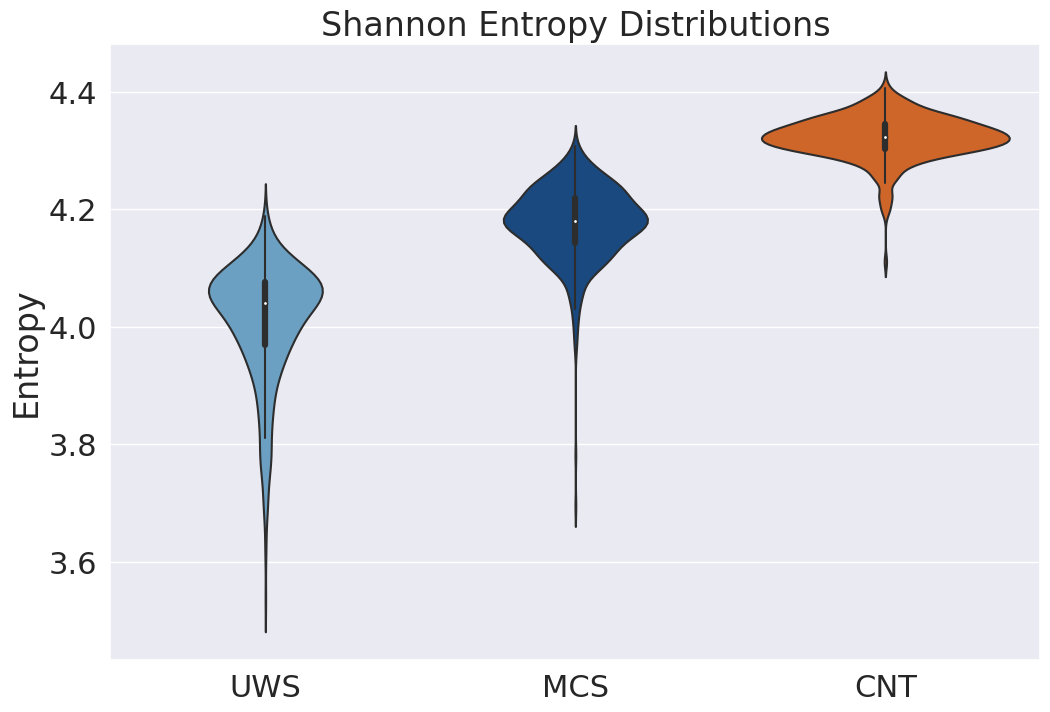

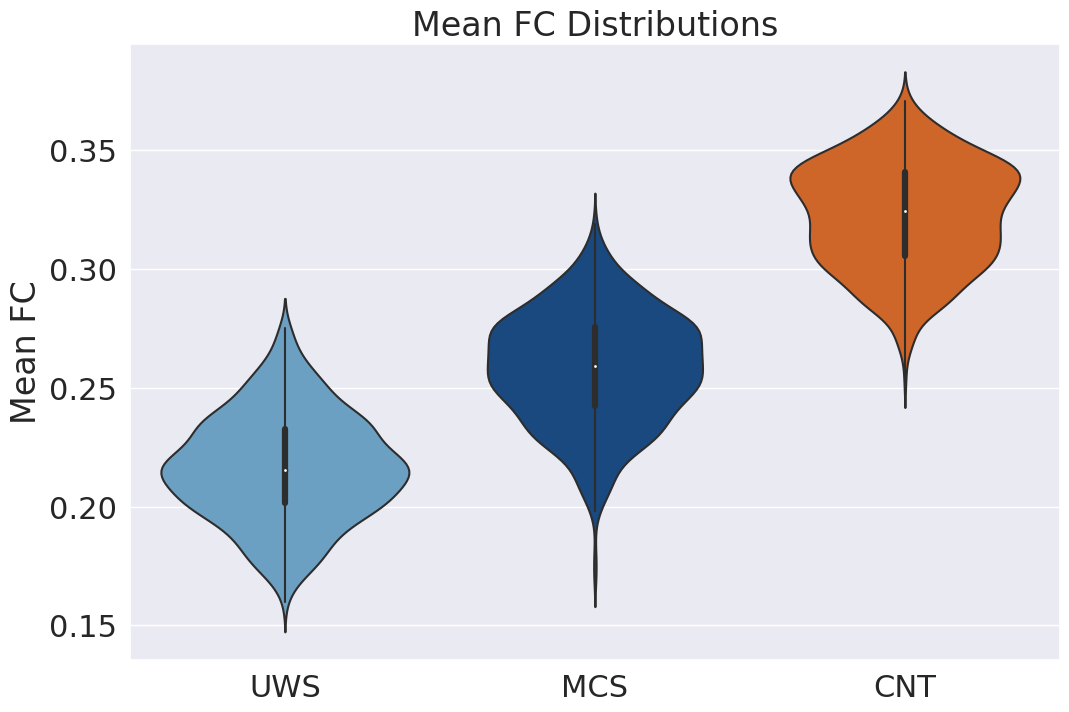

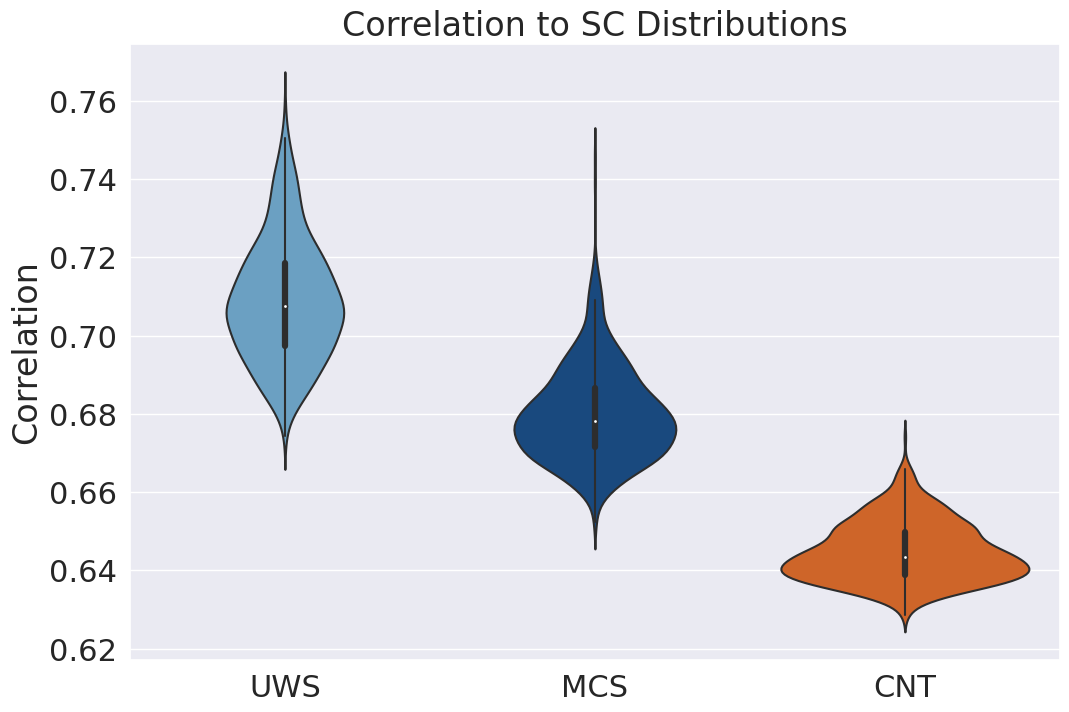

In [48]:
import matplotlib.ticker as ticker
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

#sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale
plt.figure(figsize=(fig_width, fig_height))
vlplt = sns.violinplot(x="Condition", y="Entropy", data=metrics_data, palette=baseline_colors)

calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Entropy'],metrics_data[metrics_data['Condition']=='MCS']['Entropy'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Entropy'],metrics_data[metrics_data['Condition']=='CNT']['Entropy'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Entropy'],metrics_data[metrics_data['Condition']=='CNT']['Entropy'])

plt.title("Shannon Entropy Distributions")
plt.xlabel('')
plt.savefig(f"plots/Figure3/entropyDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/entropyDistribution.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

vlplt = sns.violinplot(x="Condition", y="Mean FC", data=metrics_data, palette=baseline_colors)

plt.title("Mean FC Distributions")
plt.xlabel('')
plt.ylabel("Mean FC")
formatter = ticker.FuncFormatter(lambda x, _: f"{x:.2f}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig(f"plots/Figure3/meanFCDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/meanFCDistribution.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))


vlplt = sns.violinplot(x="Condition", y="Correlation", data=metrics_data, palette=baseline_colors)

plt.title("Correlation to SC Distributions")
plt.xlabel('')
plt.savefig(f"plots/Figure3/corr2SCDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/corr2SCDistribution.png",bbox_inches = 'tight')
plt.show()

In [49]:
print((3.097e-172)*3) 
print((2.948e-189)*3) 
print((2.318e-197)*3)

9.291000000000001e-172
8.844e-189
6.954e-197


# Fig 4

### Just baseline 

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme()

models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(12, 10))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
    #plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.5, label='Data')

    # Calculate the convex hull of the points
    points = np.column_stack((cluster_points[:, 0], cluster_points[:, 1]))
    hull = ConvexHull(points)

    # Get the indices of the points on the hull
    hull_indices = hull.vertices

    # Extract the points on the hull
    hull_points = points[hull_indices]

    # Plot the line connecting the exterior points
    hull_points = np.append(hull_points, [hull_points[0]], axis=0)
    plt.plot(hull_points[:, 0], hull_points[:, 1], '-',color=baseline_colors[idx])

    # Fill the area inside the line
    plt.fill(hull_points[:, 0], hull_points[:, 1], facecolor=baseline_colors[idx], alpha=0.3)
    plt.scatter(latent_centroids[idx][0],latent_centroids[idx][1], color=baseline_colors[idx], label=baseline_cmap[idx])
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plot

plt.xlabel("Z [0]")
plt.ylabel("Z [1]")
#plt.xlim(XLIM[0]-1, XLIM[1])
#plt.ylim(YLIM[0], YLIM[1])

# Add the legends to the plot
plt.legend()


plt.title("Latent representation of baseline FC")
#plt.savefig(f"plots/BaselineCentroids.png")
plt.show()



In [49]:
XLIM

(-5, 1)

In [50]:
YLIM

(-2, 2)

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


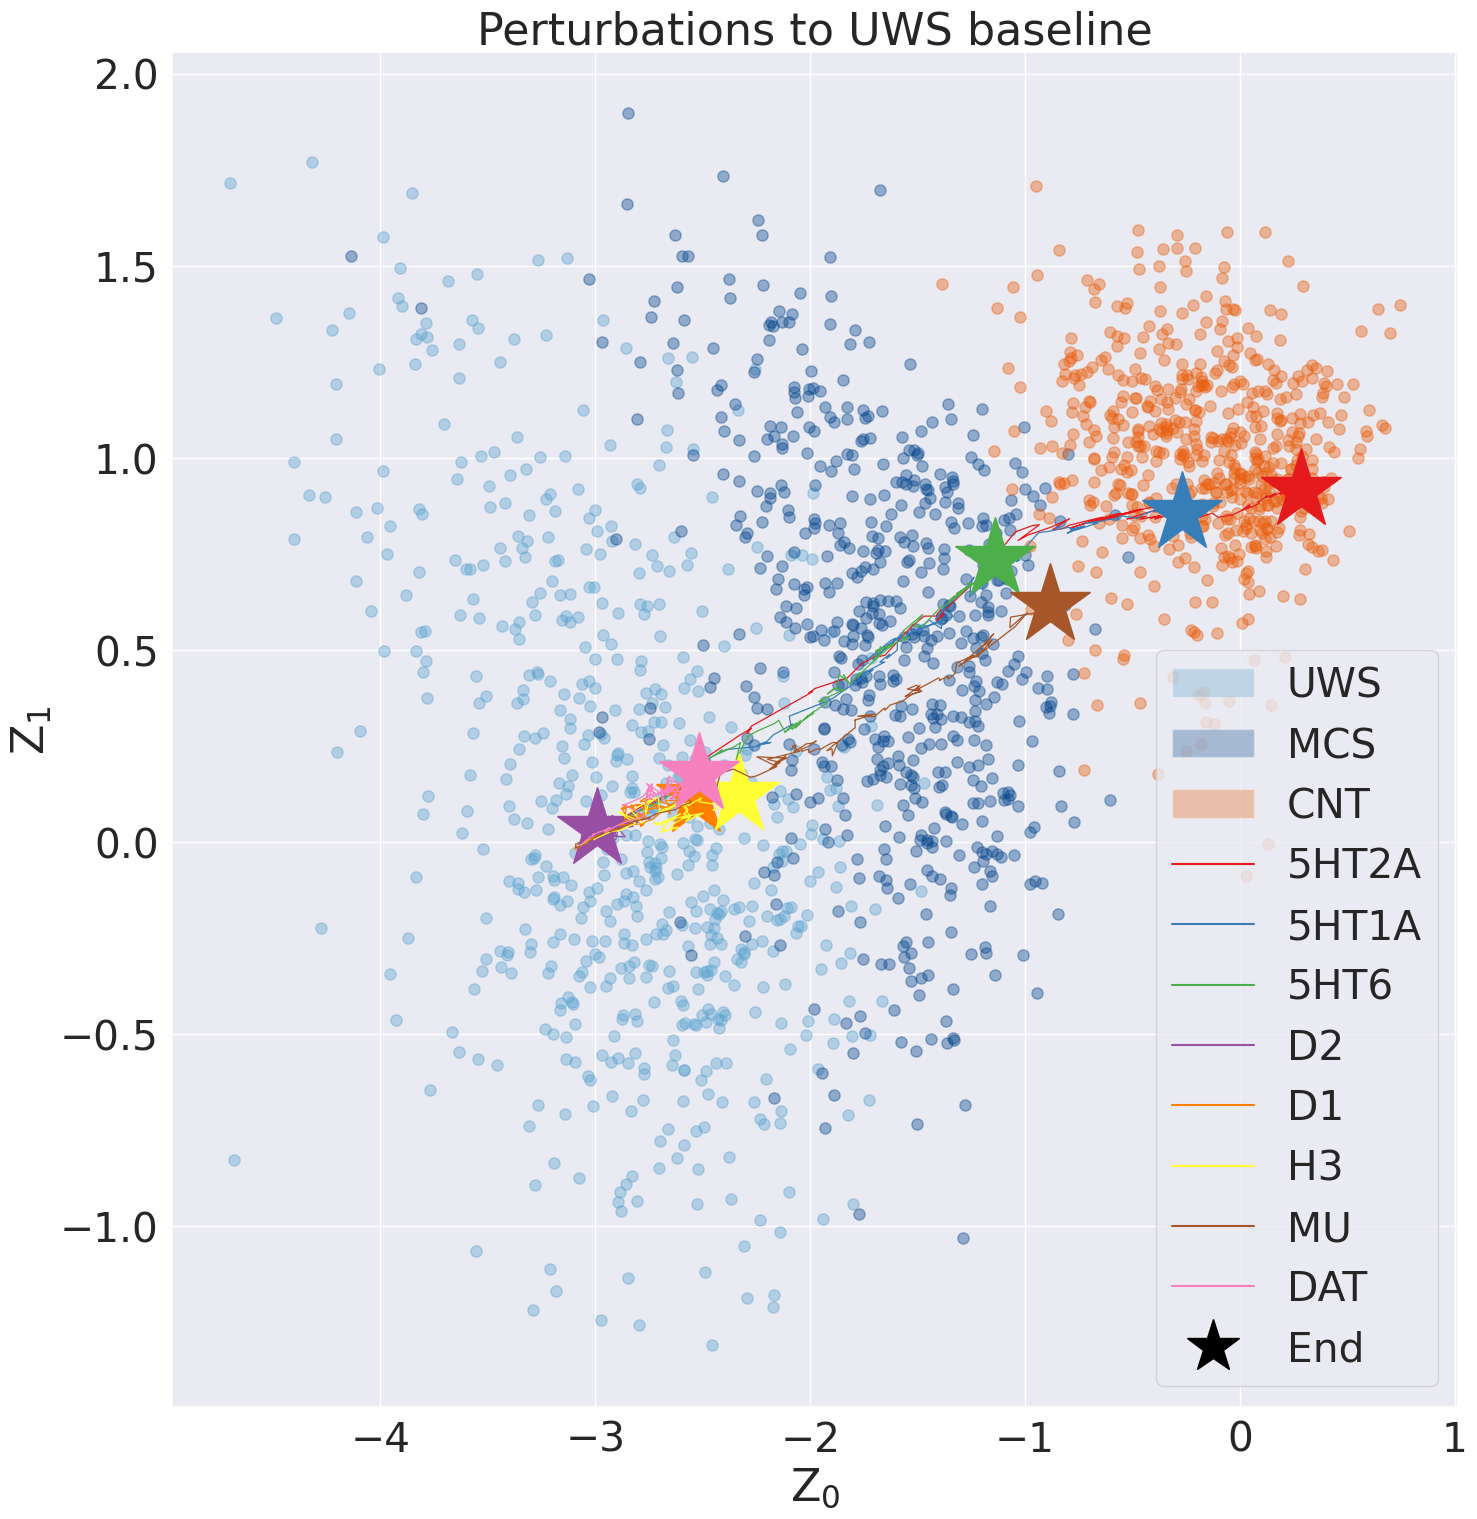

In [52]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 8.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale


models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
   
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)

UWS_distances = []
UWS_maxidx = []

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
UWS_velocities = [] 
for idx,cond in enumerate(conditions):
    # Read the FC of the peturbed simulations
    perturb_fcs = np.mean(loadmat(f"{results_path}/FC_{cond}_UWS.mat")["FC_simul_all"], axis=0)
    perturb_fcs = perturb_fcs[:101]
    # pass them to the encoder
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.zeros(shape=(101,))], batch_size=batch_size)
    # Plots the first point, the last and the whole trajectory
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=0.9)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=0.9)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [101])
    # Store the max distance and the index for later
    UWS_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    UWS_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    UWS_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed


plt.title("Perturbations to UWS baseline")
plt.savefig(f"plots/Figure4/UWS_Gain_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/UWS_Gain_ALL.png",bbox_inches = 'tight')
plt.show()


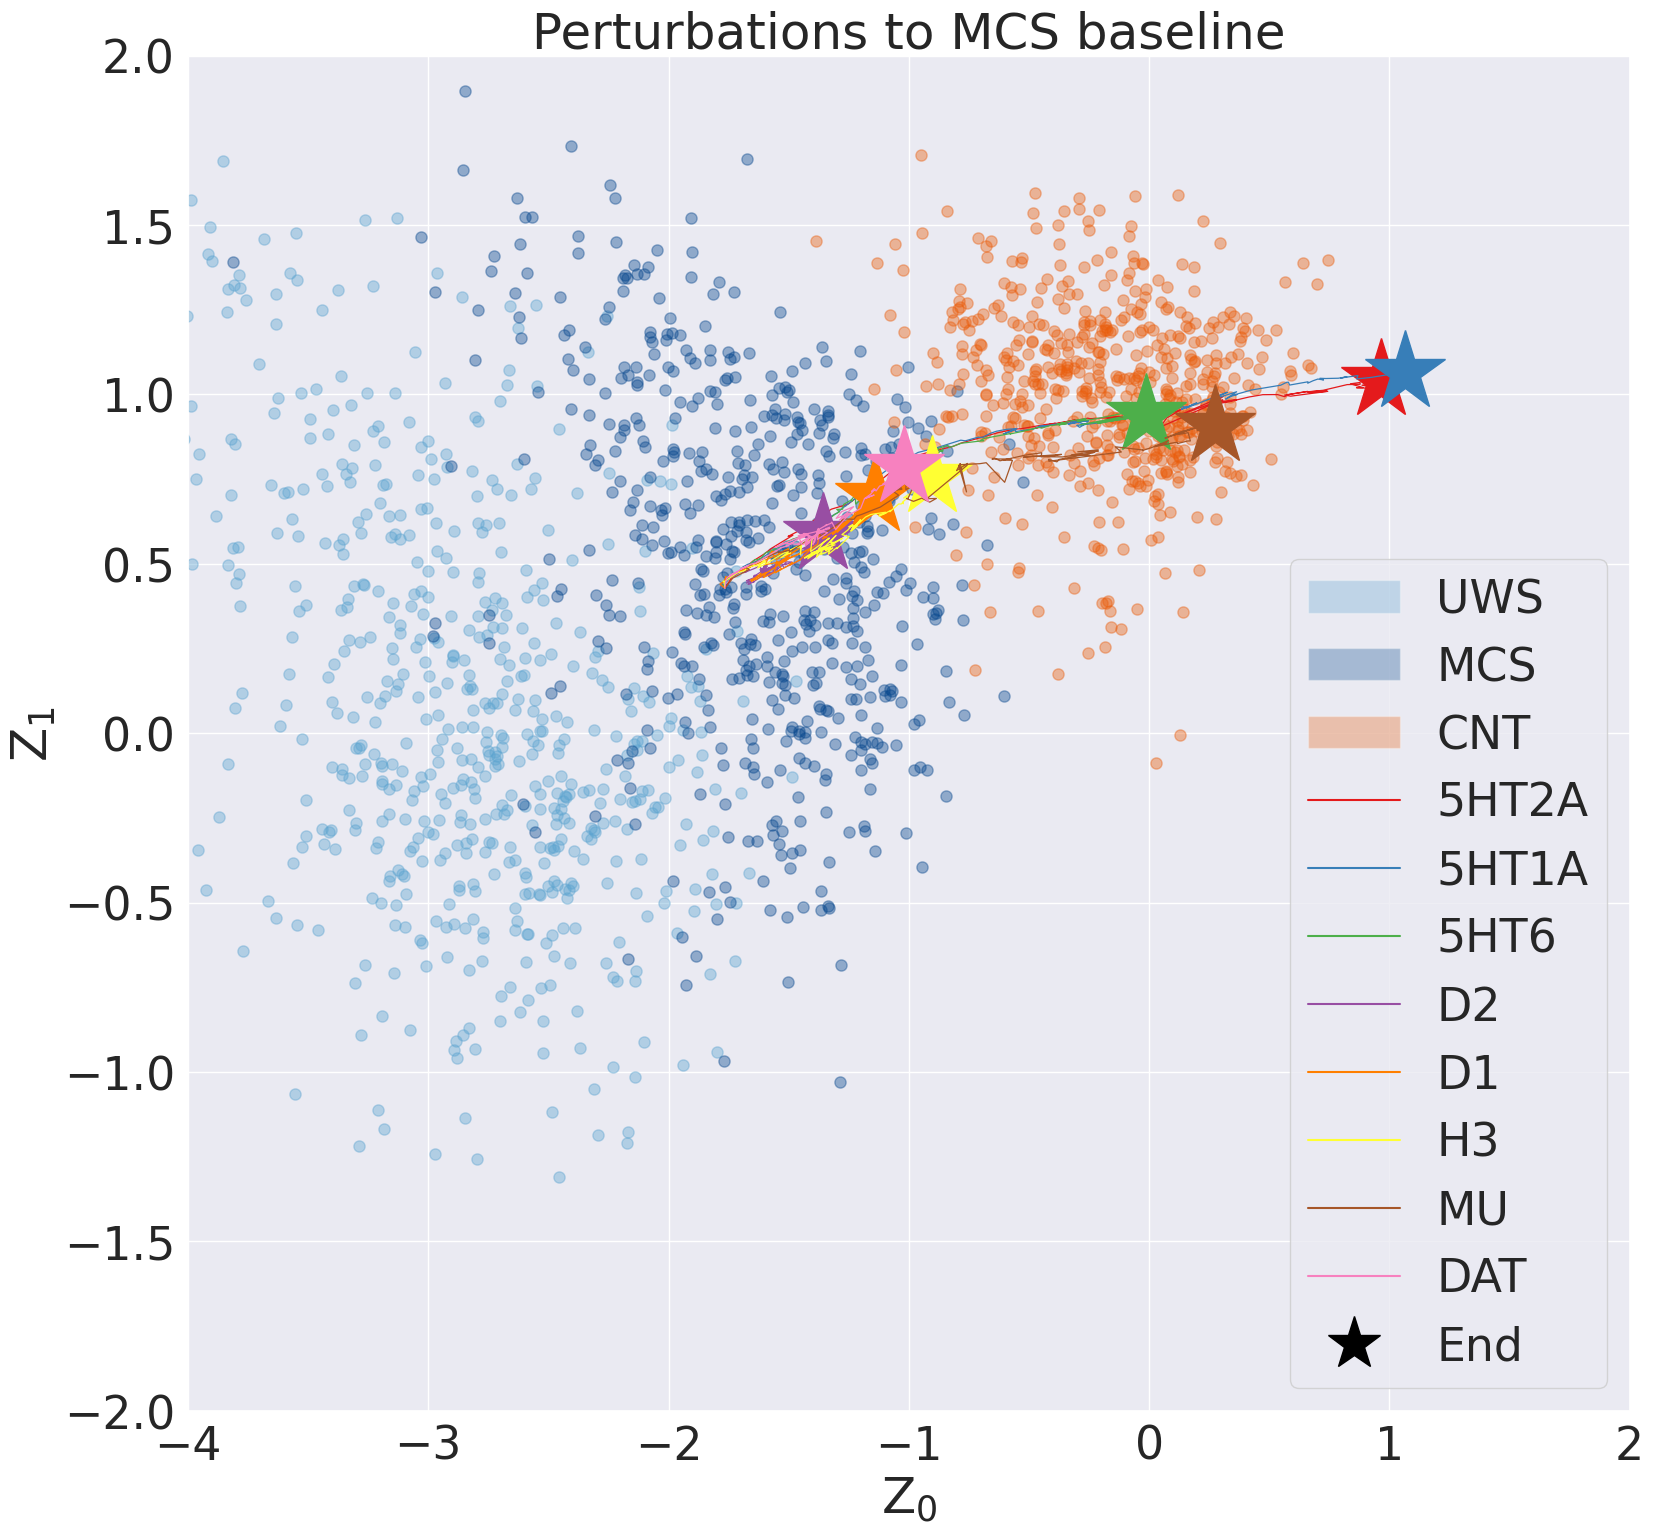

In [59]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 9.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 18 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale



plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
    
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

MCS_distances = []
MCS_maxidx = []

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
MCS_velocities = [] 
for idx,cond in enumerate(conditions):
    perturb_fcs = np.mean(loadmat(f"{results_path}/FC_{cond}_MCS.mat")["FC_simul_all"],axis=0)
    perturb_fcs = perturb_fcs[:101]
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.ones((101,))], batch_size=batch_size)
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=0.9)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=0.9)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [101])
    MCS_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    MCS_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    MCS_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.xlim(XLIM[0]+1, XLIM[1]+1)
plt.ylim(YLIM[0], YLIM[1])
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed


plt.title("Perturbations to MCS baseline")
plt.savefig(f"plots/Figure4/MCS_Gain_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/MCS_Gain_ALL.png",bbox_inches = 'tight')
plt.show()


## Distance distributions to CNT after perturbing

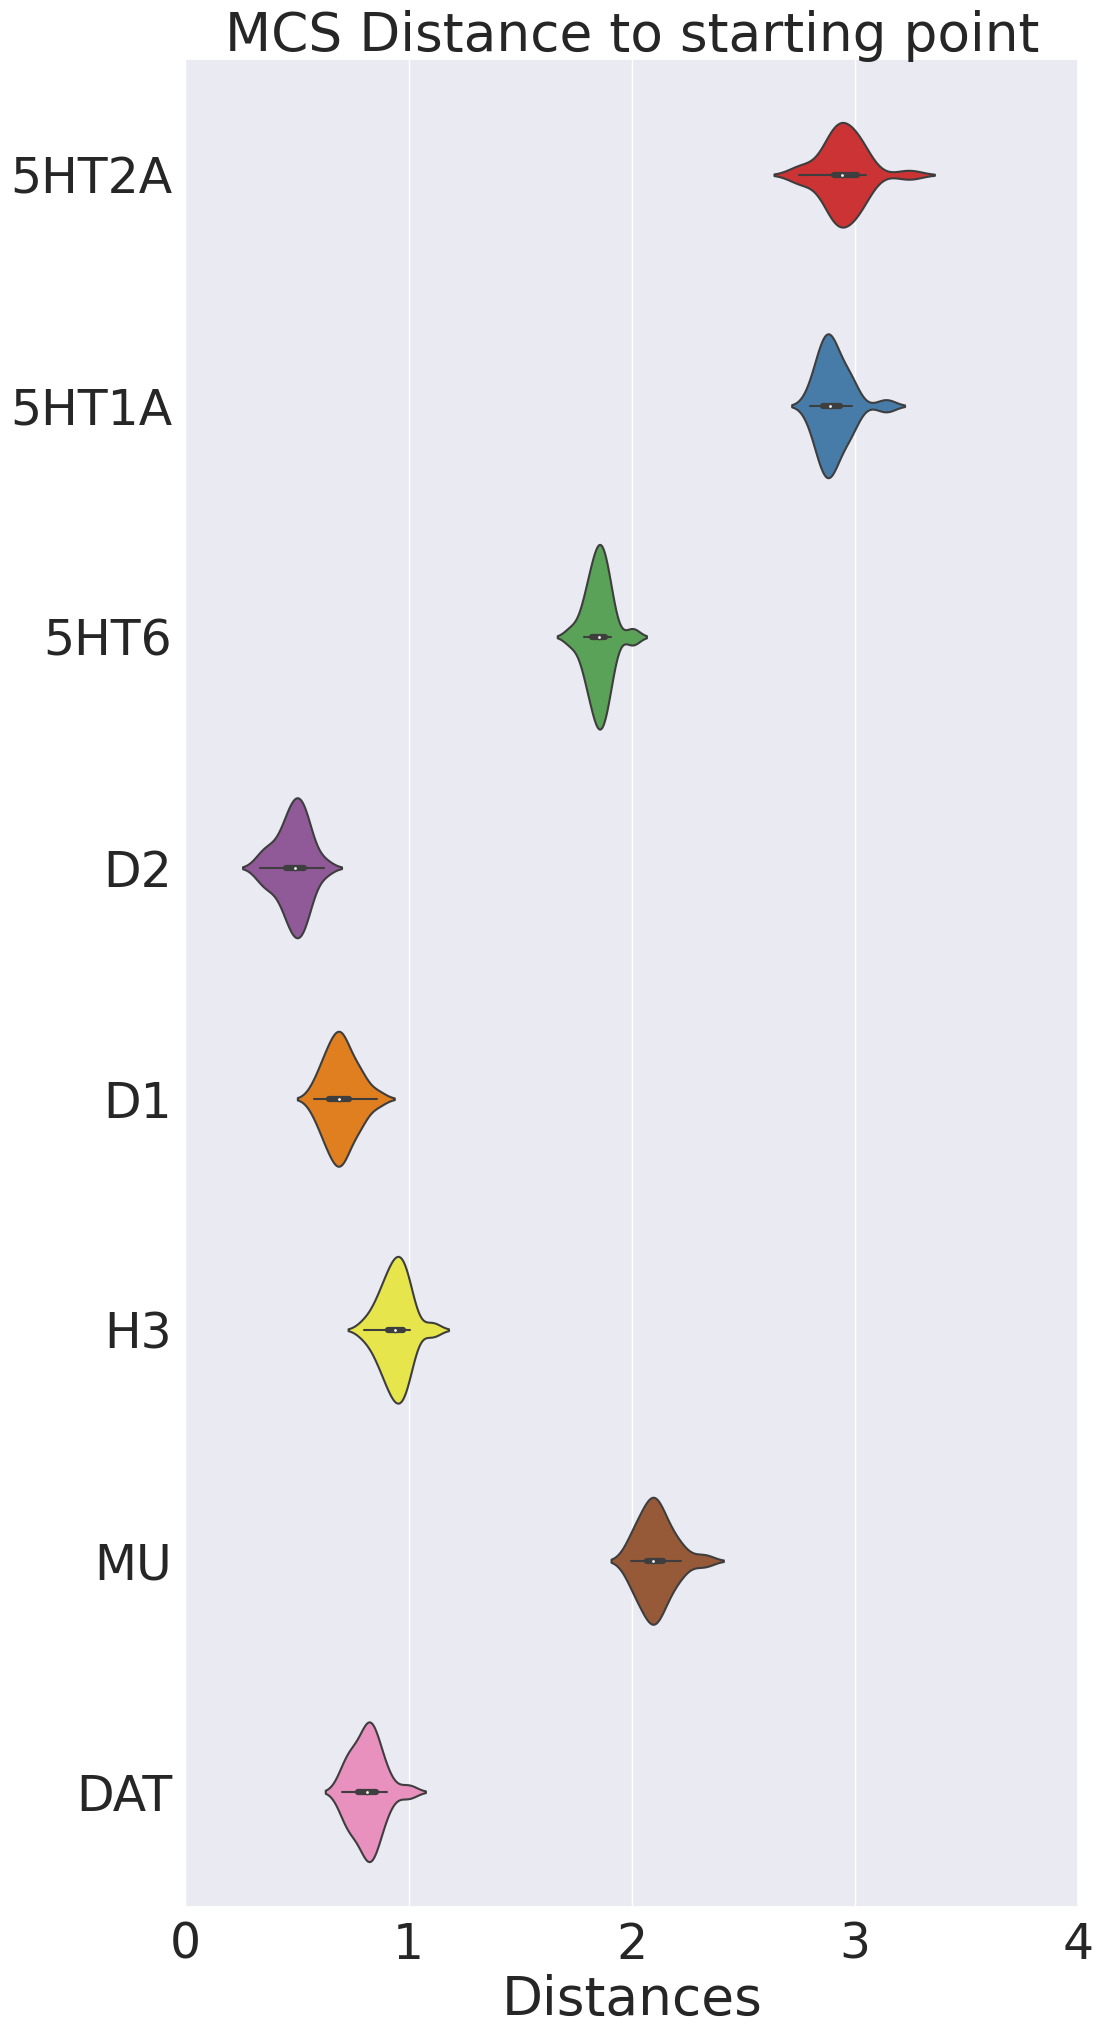

In [65]:


# Define the scaling factor
scaling_factor = 2.4
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 4.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
#conditions = ['5HT2A', '5HT1A']
MCS_distances = np.zeros((20, len(conditions)))
MCS_maxidx = np.zeros((20, len(conditions)))
MCS_velocities = np.zeros((20, len(conditions),100)) # We dont take the velocity at time 0, so in total we have 100 points
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
for idx,cond in enumerate(conditions):
    perturb_fcs = loadmat(f"{results_path}/FC_{cond}_MCS.mat")["FC_simul_all"] 
    for rep in range(20):
        perturb_fcs_rep = perturb_fcs[rep, :, :,:] # Shape (rep, scale, nreg, nreg)
        z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs_rep,(101,90*90)),np.ones(shape=(101,))], batch_size=batch_size)        

        latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
        latent_dist = np.reshape(latent_dist, [101])
        
        MCS_distances[rep, idx] = (np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        MCS_maxidx[rep, idx] = (np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        MCS_velocities[rep, idx, :] = calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb)

data = MCS_distances

# Create the violin plot
fig, ax = plt.subplots(figsize=(fig_height,fig_width))
sns.violinplot(data,palette=condition_colors, showmedians=True, widths=0.7, showextrema=False, ax=ax, orient='h')

# Set custom colors for each category
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(condition_colors[i])


ax.set_yticklabels(conditions)
plt.xticks()
plt.xlim([0,4])
plt.xlabel('Distances')
plt.title('MCS Distance to starting point')
plt.savefig(f"plots/Figure4/MCS_DistanceToStart.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/MCS_DistanceToStart.png",bbox_inches = 'tight')
# Display the plot
plt.show()

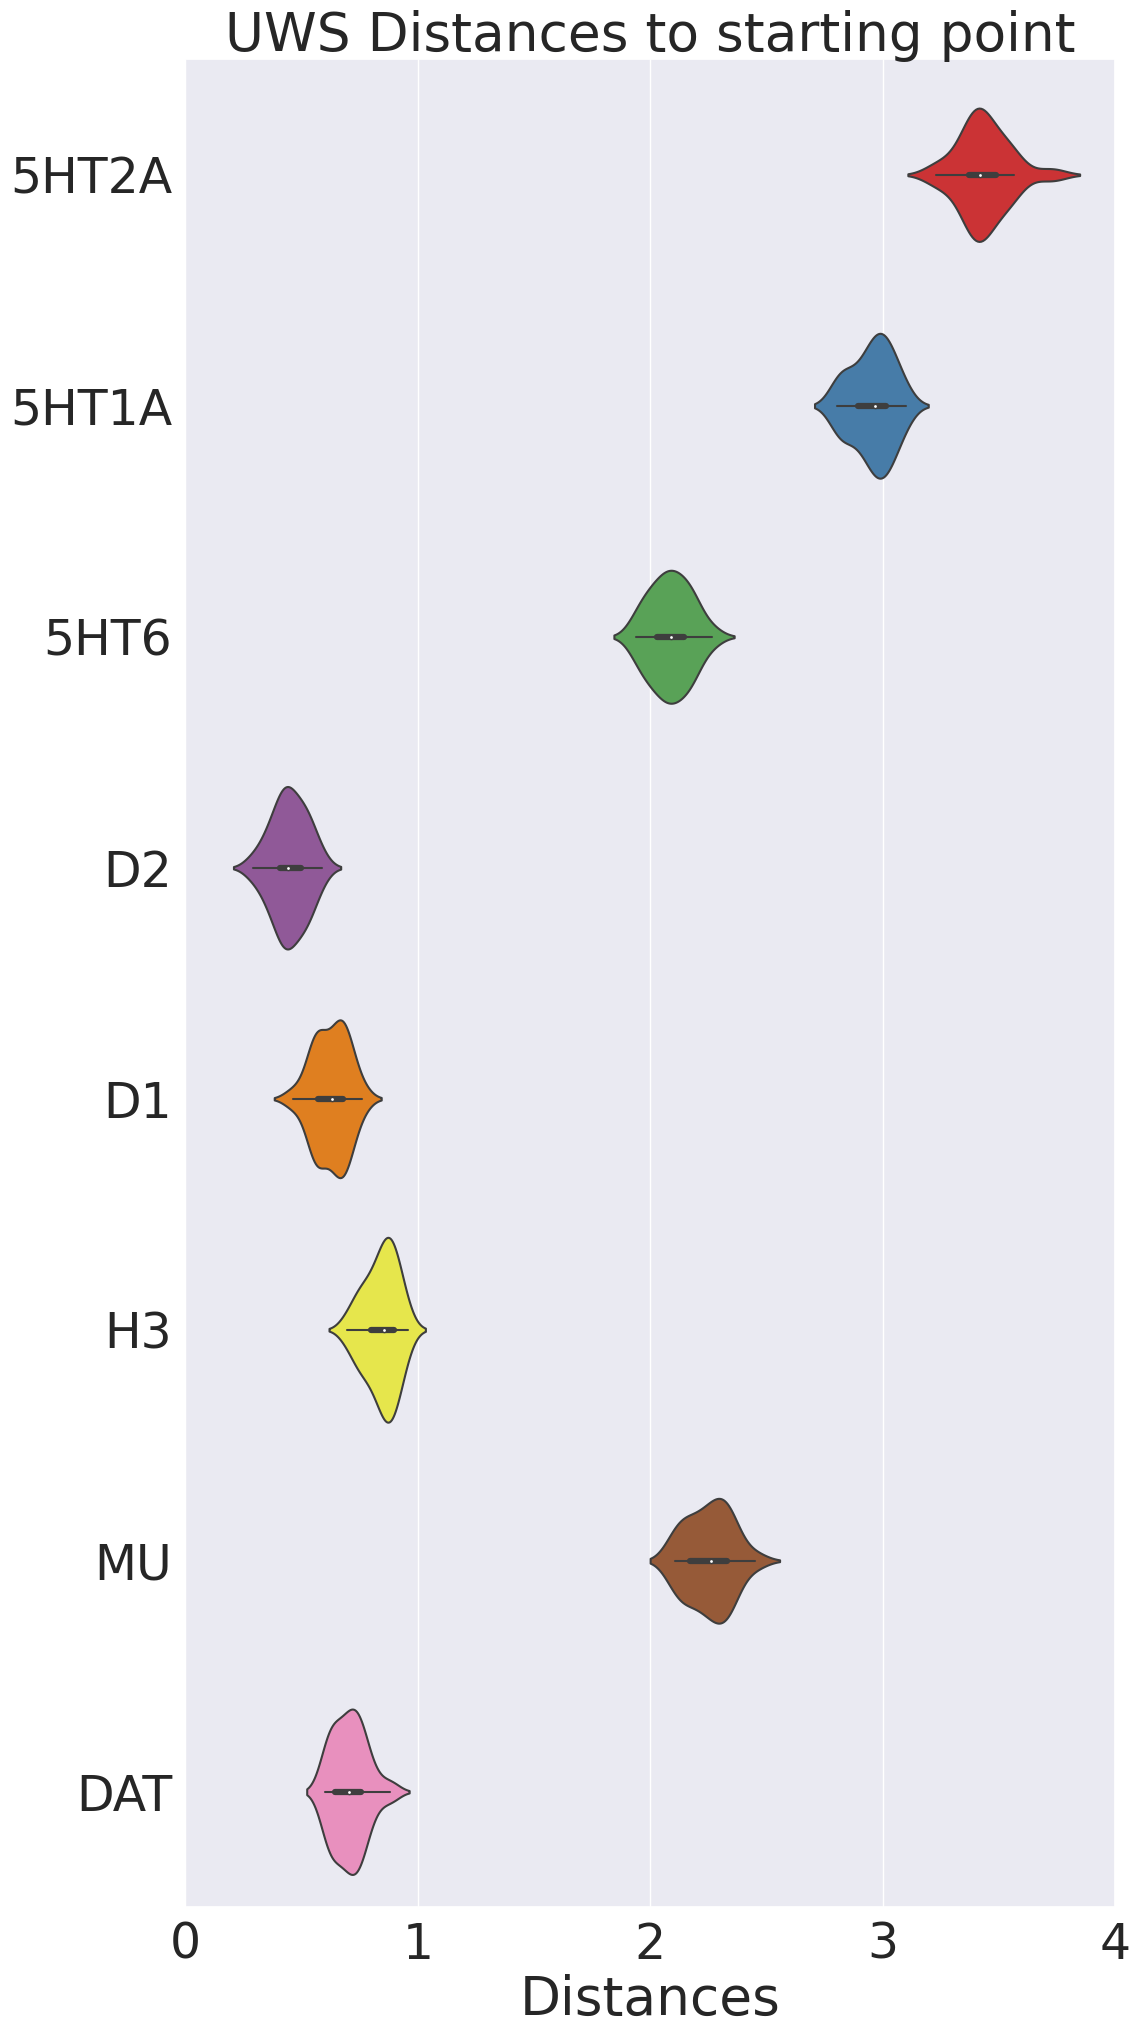

In [66]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl


# Define the scaling factor
scaling_factor = 2.4
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 5 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

#conditions = ['5HT2A', '5HT1A']
UWS_distances = np.zeros((20, len(conditions)))
UWS_maxidx = np.zeros((20, len(conditions)))
UWS_velocities = np.zeros((20, len(conditions),100)) # We dont take the velocity at time 0, so in total we have 100 points
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
for idx,cond in enumerate(conditions):
    perturb_fcs = loadmat(f"{results_path}/FC_{cond}_UWS.mat")["FC_simul_all"]
    for rep in range(20):
        perturb_fcs_rep = perturb_fcs[rep, :, :,:] # Shape (rep, scale, nreg, nreg)
        z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs_rep,(101,90*90)),np.ones(shape=(101,))], batch_size=batch_size)        

        latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
        latent_dist = np.reshape(latent_dist, [101])
        #savemat(os.path.join(base_cluster,"Results",f"UWS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
        UWS_distances[rep, idx] = (np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        UWS_maxidx[rep, idx] = (np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        UWS_velocities[rep, idx, :] = calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb)


data = UWS_distances
# Create the violin plot
fig, ax = plt.subplots(figsize=(fig_height,fig_width))
sns.violinplot(data,palette=condition_colors, showmedians=True, widths=0.7, showextrema=False, ax=ax, orient='h')

# Set custom colors for each category
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(condition_colors[i])

# Customize the plot
ax.set_yticklabels(conditions)
plt.xticks()
plt.xlim([0,4])
plt.xlabel('Distances')
plt.title('UWS Distances to starting point')
plt.savefig(f"plots/Figure4/UWS_DistanceToStart.png",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/UWS_DistanceToStart.svg",bbox_inches = 'tight')
plt.show()

# Fig 5

In [68]:
from numpy import genfromtxt
from matplotlib.ticker import FuncFormatter

def format_ticks(value, pos):
    """
    Used to control the format of the ticks
    """
    return f'{value:.1f}'  # Format ticks as floats with 2 decimal places

receptors_mean_pets = []
base_receptor_path = 'receptors/'

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

receptor_fnames = [
    '5HT2a_cimbi_hc29_beliveau.csv',  
 '5HT1a_cumi_hc8_beliveau.csv',
 '5HT6_gsk_hc30_radhakrishnan.csv',
 'D2_flb457_hc37_smith.csv',     
 'D1_SCH23390_hc13_kaller.csv',       
    'H3_cban_hc8_gallezot.csv', 
 'MU_carfentanil_hc204_kantonen.csv',
 'DAT_fpcit_hc174_dukart_spect.csv']
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    receptors_mean_pets.append(np.mean(ratio))

In [71]:
from numpy import genfromtxt
from scipy.stats import pearsonr

weight_SC = np.load(os.path.join(results_path,"SC_weights.npy"))
weighted_receptors_mean_pets = []
base_receptor_path = '/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/AAL'
conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
receptor_fnames = [
    '5HT2a_cimbi_hc29_beliveau.csv',  
 '5HT1a_cumi_hc8_beliveau.csv',
 '5HT6_gsk_hc30_radhakrishnan.csv',
 'D2_flb457_hc37_smith.csv',     
 'D1_SCH23390_hc13_kaller.csv',       
    'H3_cban_hc8_gallezot.csv', 
 'MU_carfentanil_hc204_kantonen.csv',
 'DAT_fpcit_hc174_dukart_spect.csv']


receptors = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    receptors.append(ratio)

receptor_density  = np.mean(np.array(ratio), axis=1)
weight_vector = weight_SC

receptor_min = np.min(receptor_density)
receptor_max = np.max(receptor_density)

# Step 2: Determine min and max values of weight vector
weight_min = np.min(weight_vector)
weight_max = np.max(weight_vector)

# Step 3: Rescale weight vector
rescaled_weight_vector = ((weight_vector - weight_min) / (weight_max - weight_min)) * (receptor_max - receptor_min) + receptor_min

weight_density_corrs = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    c,p = pearsonr(np.squeeze(ratio), rescaled_weight_vector)
    receptor_tag = receptor_fname.split("_")[0]
    #print(f"Correlation with Weight for {receptor_tag}\nCorr: {c:.2f} - P-value: {p:.4f}")
    weight_density_corrs.append(c)



weight_density_distance = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    c,p = pearsonr(np.squeeze(ratio), rescaled_weight_vector)
    receptor_tag = receptor_fname.split("_")[0]
    #print(f"Correlation with Weight for {receptor_tag}\nCorr: {c:.2f} - P-value: {p:.4f}")
    weight_density_distance.append(np.linalg.norm(np.squeeze(ratio)-rescaled_weight_vector))


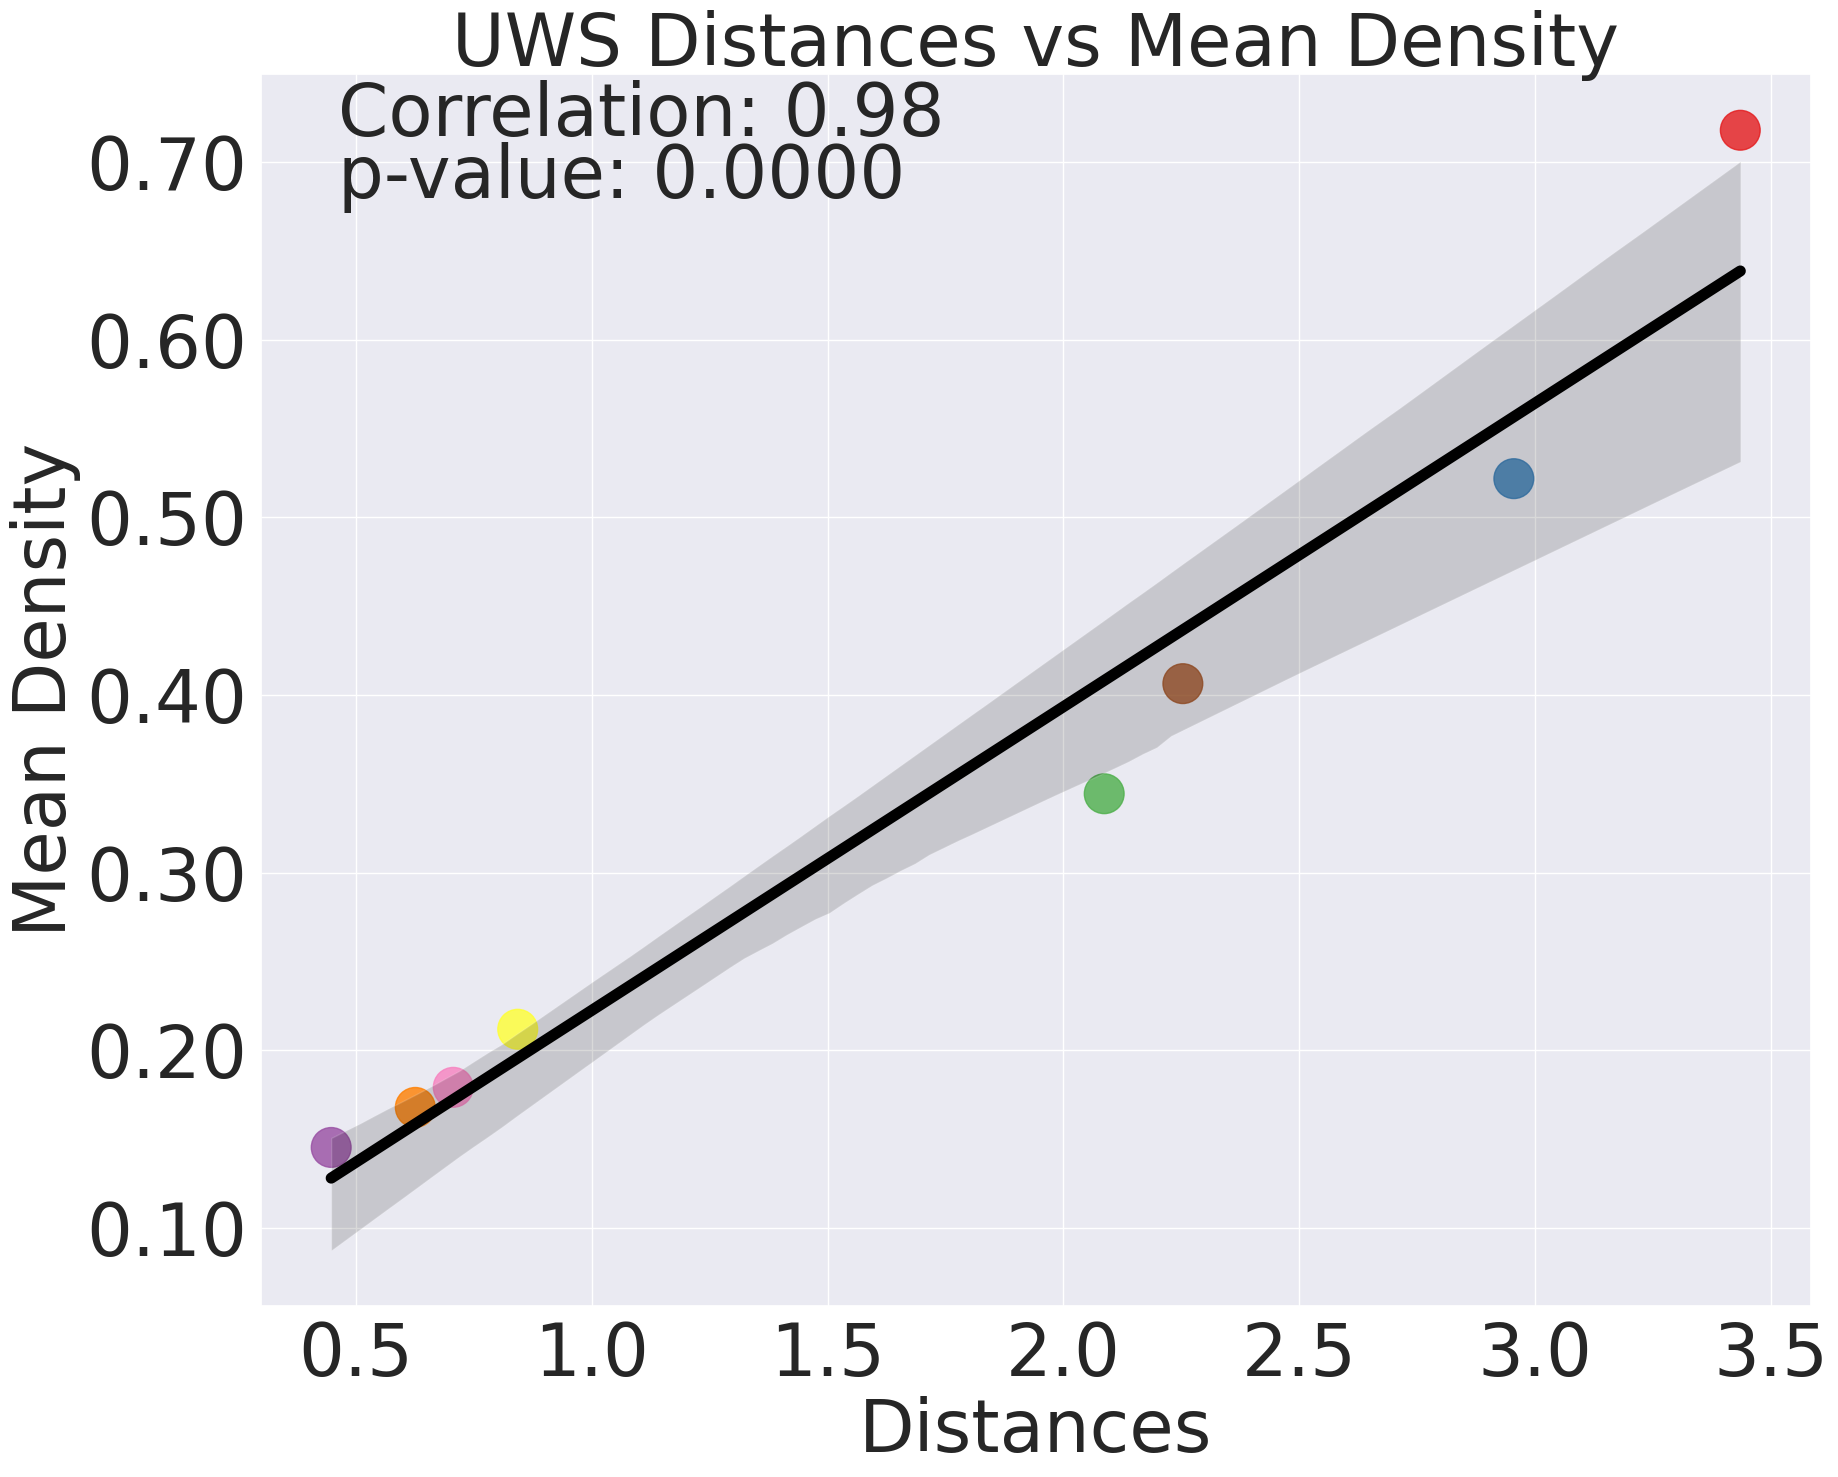

Correlation: 0.9770365930248571
p-value: 2.9753571896039607e-05


In [72]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(UWS_distances,axis=0)
mean_values = receptors_mean_pets

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Mean Density', fontsize=font_size)
plt.title('UWS Distances vs Mean Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/UWS_DistanceVsDensity.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceVsDensity.png",bbox_inches = 'tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


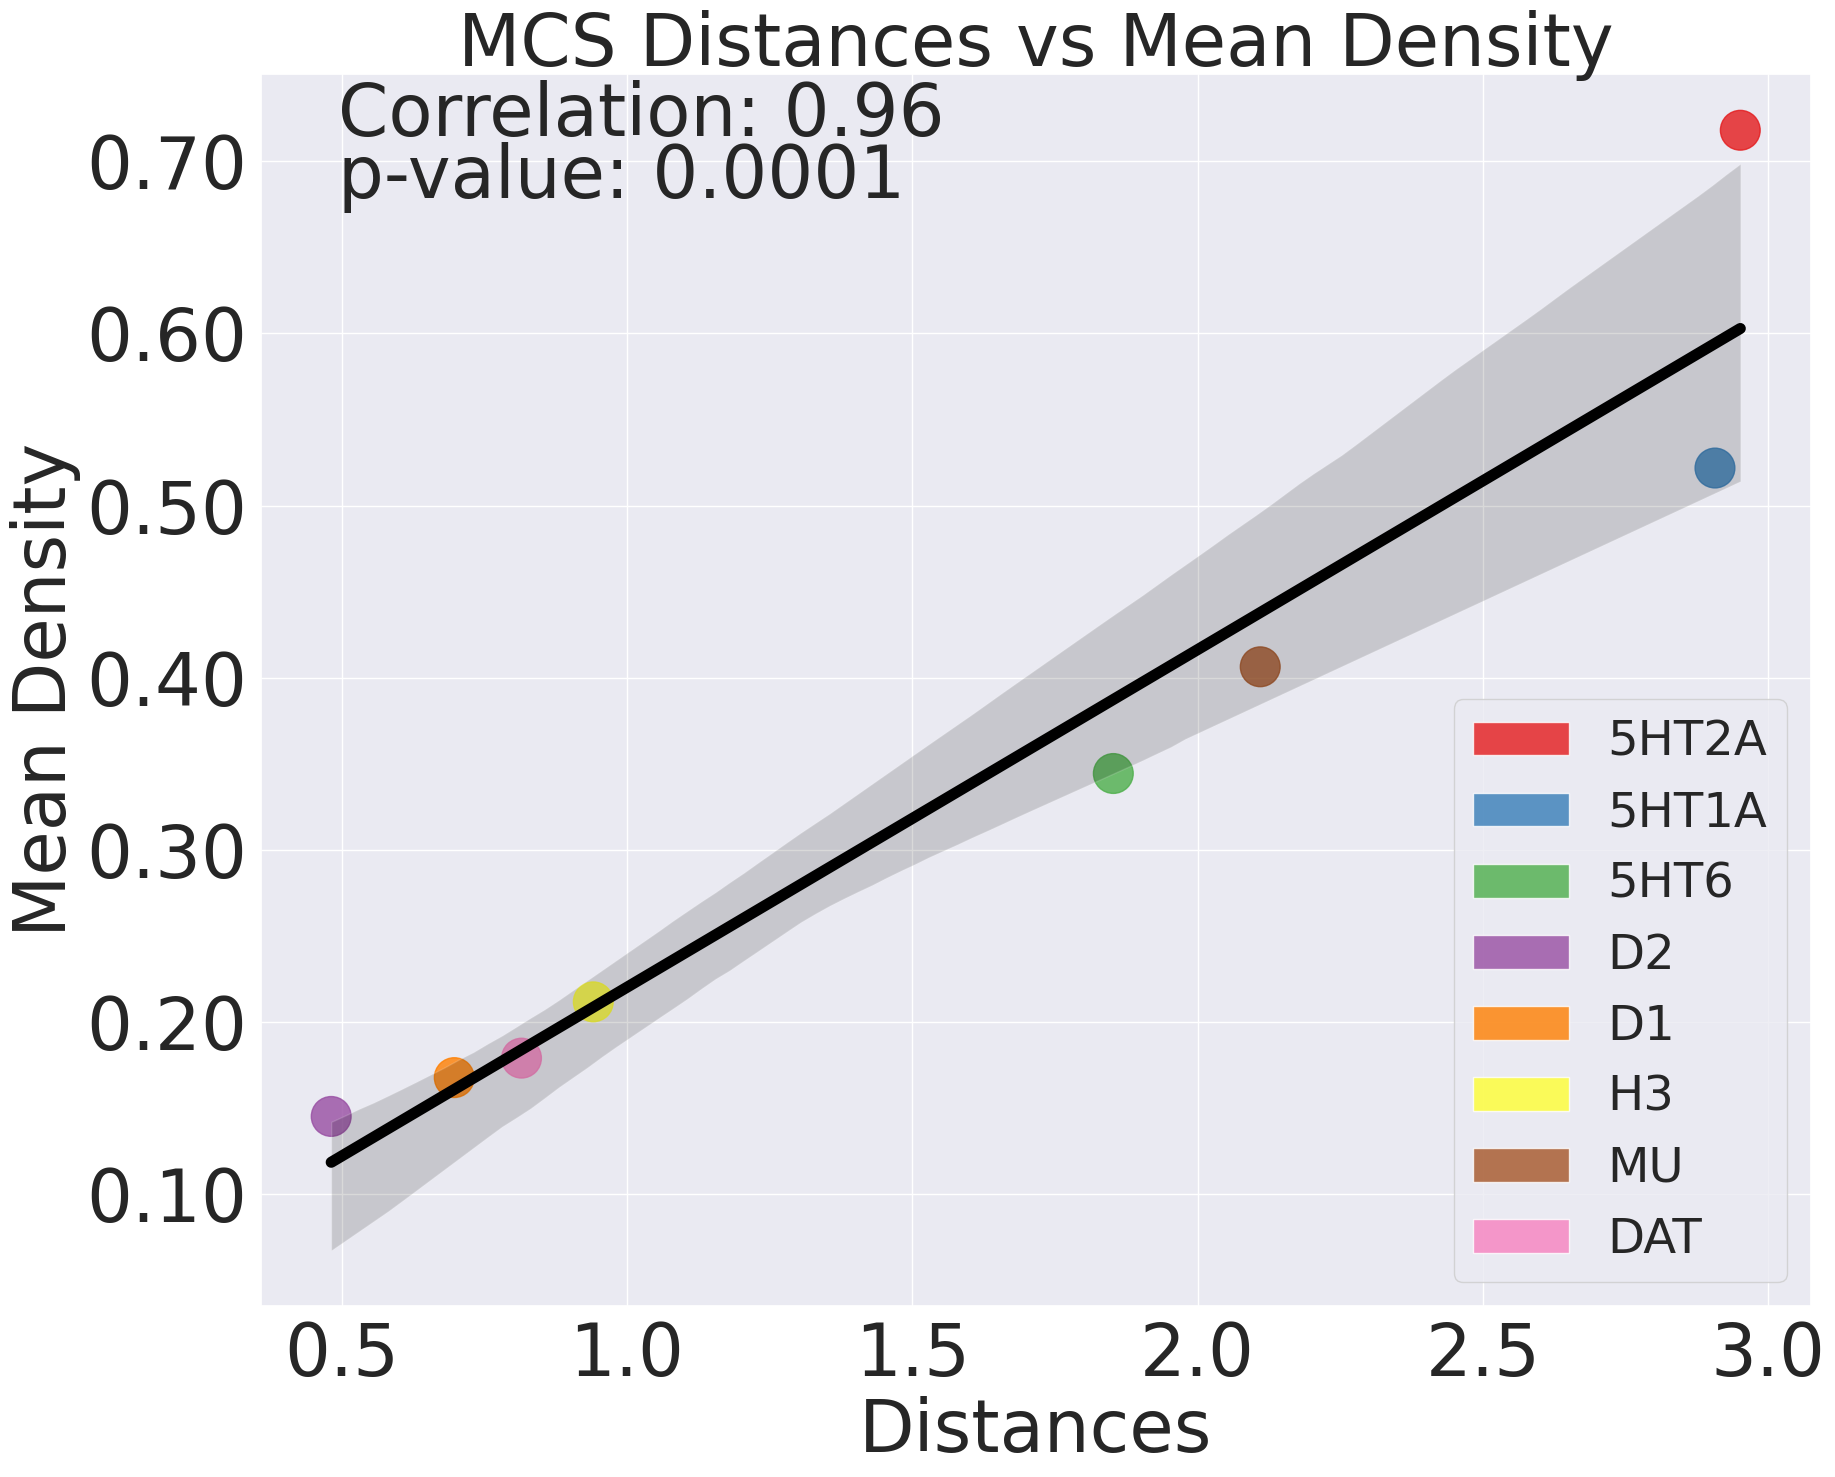

Correlation: 0.9611319660768561
p-value: 0.0001425511621608232


In [73]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor


distances = np.mean(MCS_distances,axis=0)
mean_values = receptors_mean_pets
correlation, p_value = pearsonr(distances, mean_values)
#fig, ax = plt.subplots(figsize=(10,9))
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Mean Density', fontsize=font_size)
plt.title('MCS Distances vs Mean Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")


plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

legend_handles = [mpatches.Patch(facecolor=condition_colors[idx],alpha=0.8, label=conditions[idx]) for idx in range(len(conditions))]
legend = plt.legend(handles=legend_handles, loc='center right')
for lh in legend.legendHandles:
    lh._sizes = [200]  # Adjust the marker size as needed

plt.legend(handles=legend_handles, loc="lower right", fontsize=font_size-(font_size/3))


plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/MCS_DistanceVsDensity.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceVsDensity.png",bbox_inches = 'tight')
plt.show()

print("Correlation:", correlation)
print("p-value:", p_value)


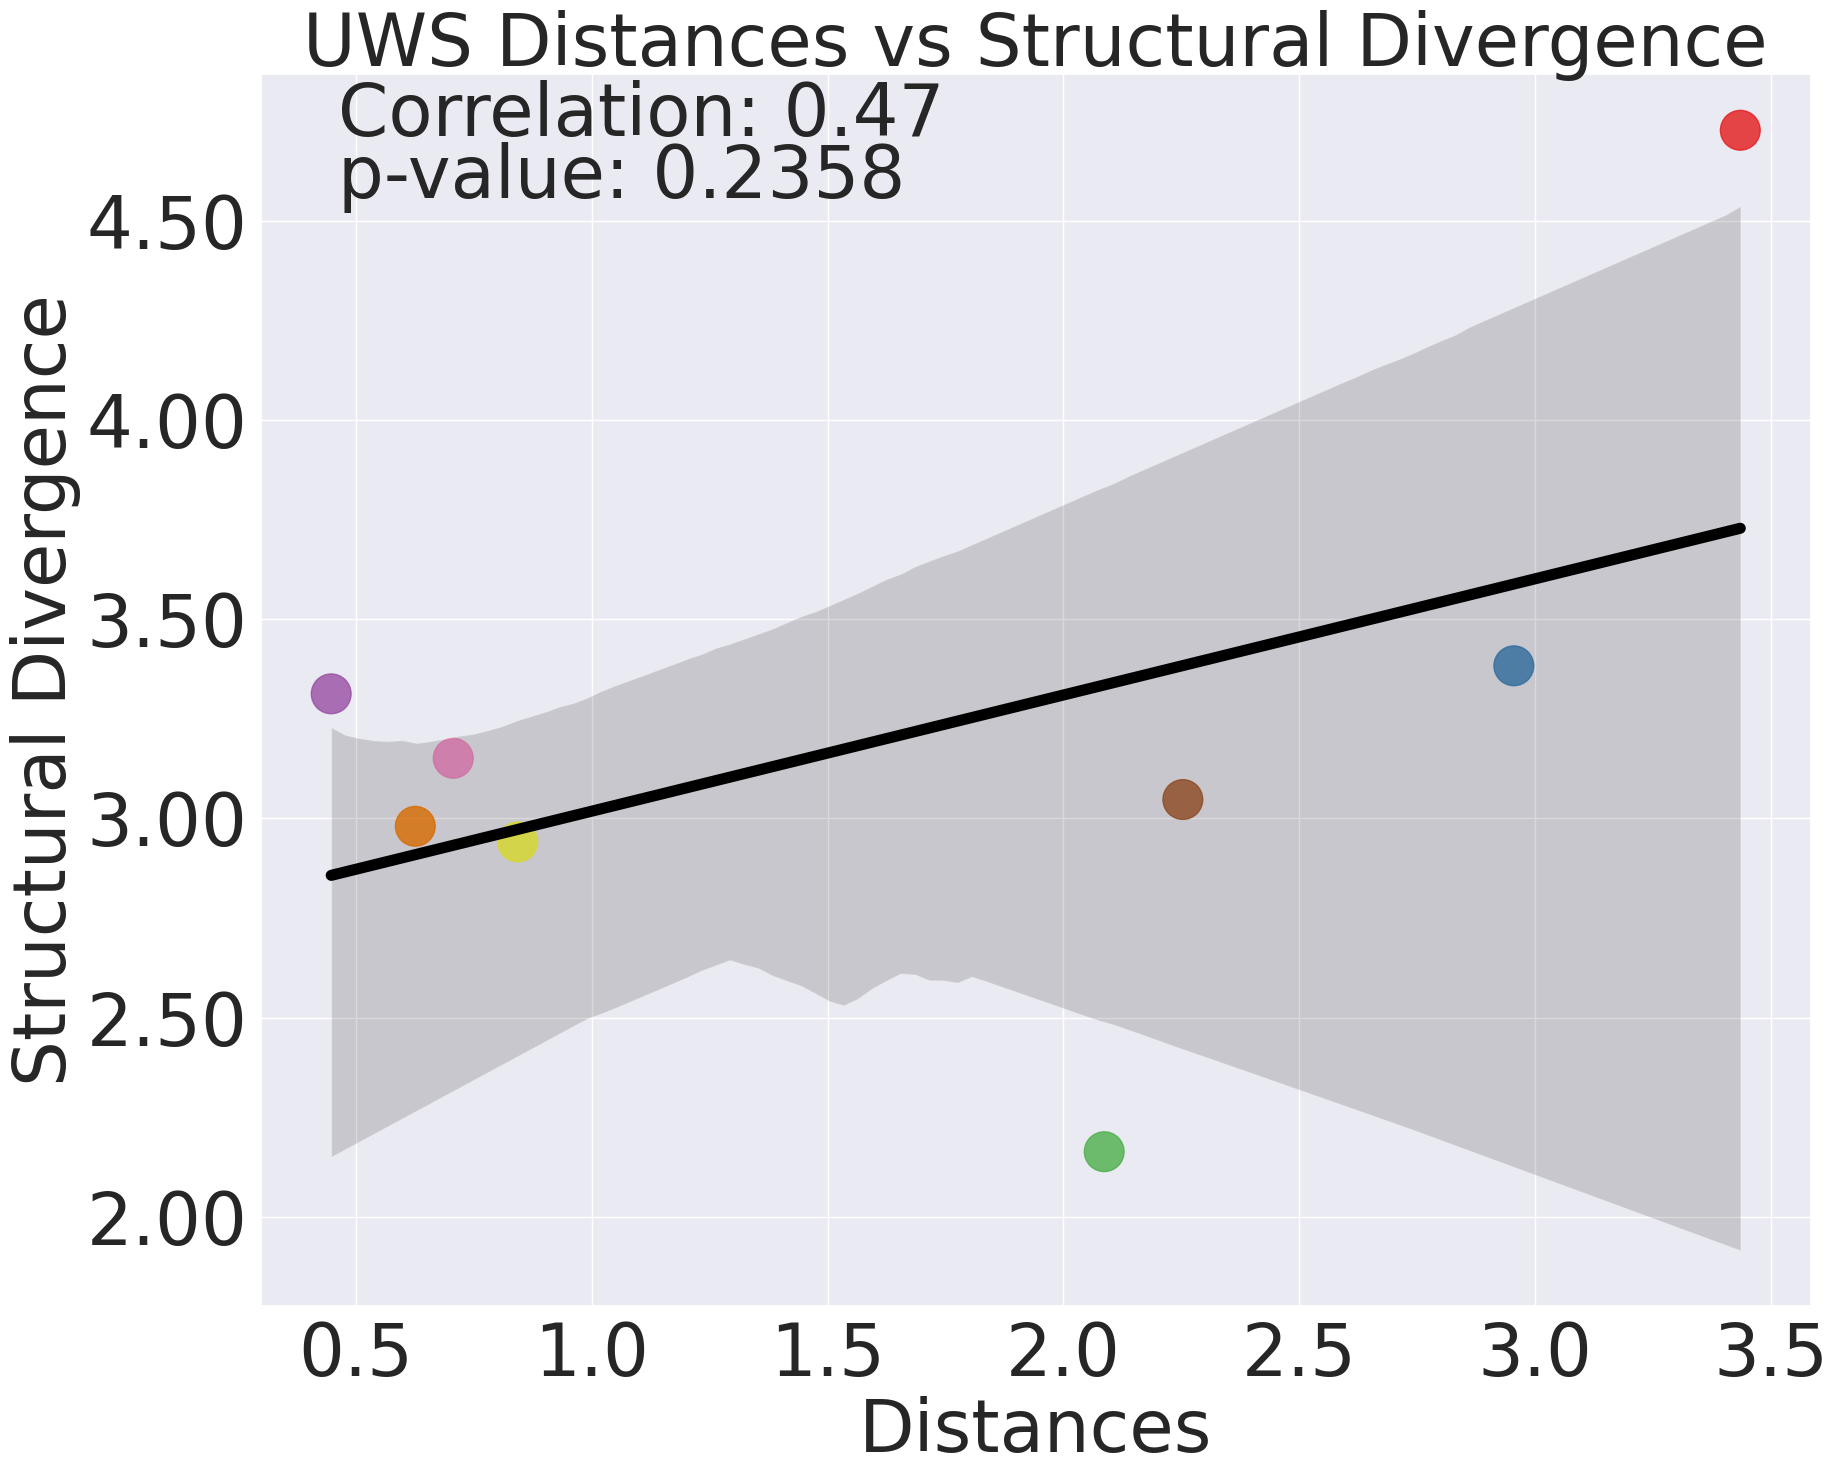

Correlation: 0.47359978784845924
p-value: 0.23584913884812025


In [75]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(UWS_distances,axis=0)
mean_values = weight_density_distance

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Divergence', fontsize=font_size)
plt.title('UWS Distances vs Structural Divergence', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/UWS_DistanceVsStructure.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceVsStructure.png", bbox_inches='tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


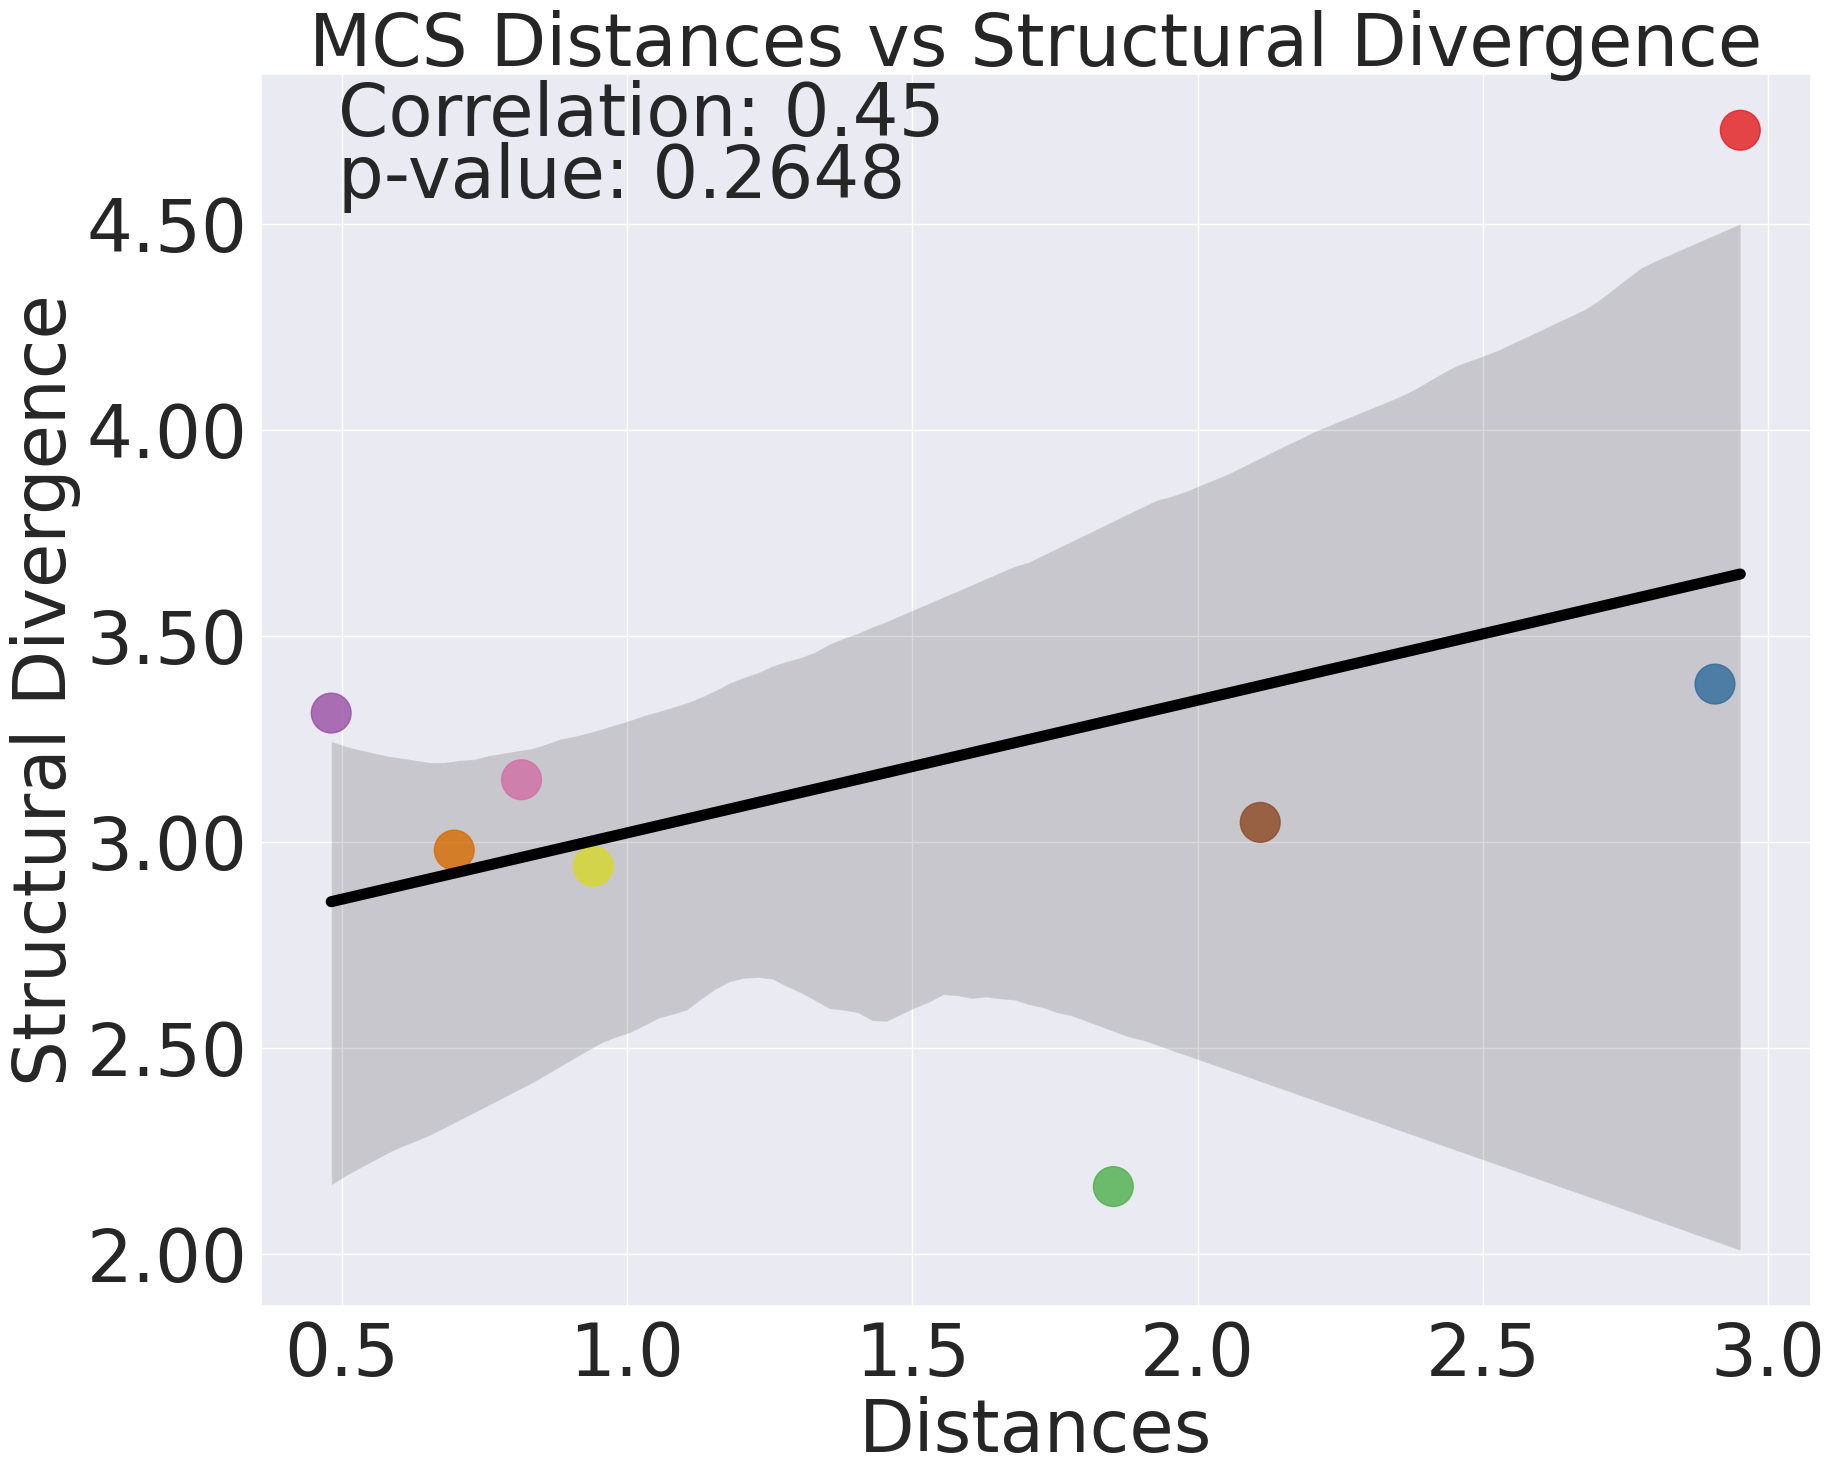

Correlation: 0.4486583504851699
p-value: 0.26483879933156734


In [76]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))

distances = np.mean(MCS_distances,axis=0)
mean_values = weight_density_distance
correlation, p_value = pearsonr(distances, mean_values)
#fig, ax = plt.subplots(figsize=(10,9))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Divergence', fontsize=font_size)
plt.title('MCS Distances vs Structural Divergence', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/MCS_DistanceVsStrcutre.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceVsStrcutre.png",bbox_inches = 'tight')
plt.show()

print("Correlation:", correlation)
print("p-value:", p_value)


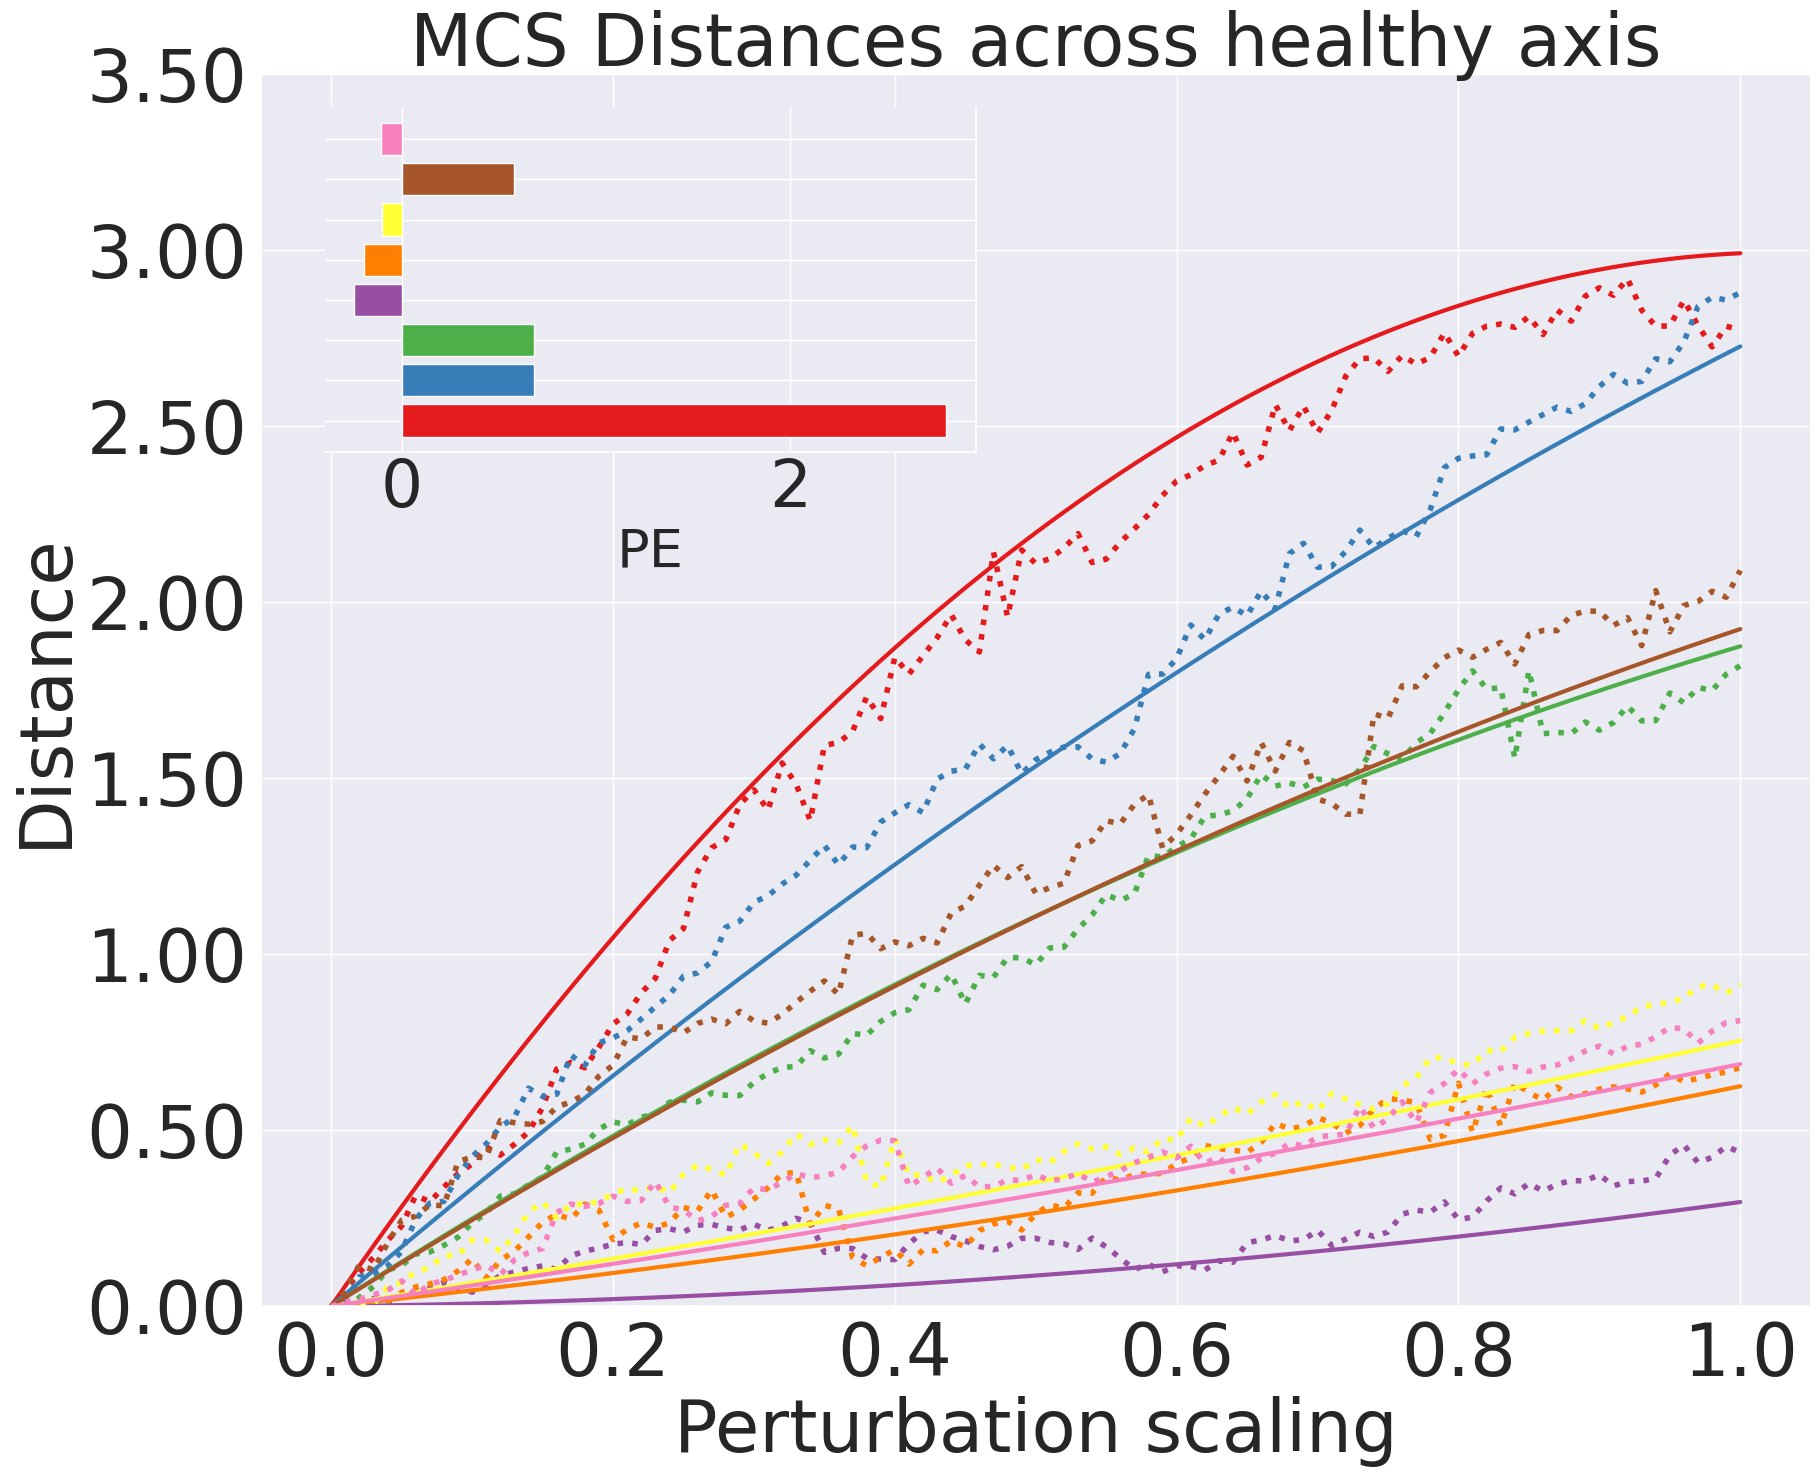

In [77]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,Bbox
def poly_func_3(x, a, b, c,d):
    return a * x**3 + b * x ** 2+ c * x + d  # You can adjust the degree of the polynomial
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c  # You can adjust the degree of the polynomial


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

MCS_speed_curves = list(map(lambda inst_speeds: np.cumsum([0]+inst_speeds), np.mean(MCS_velocities,axis=0)))
MCS_speed_curves = [np.insert(subarray, 0, 0) for subarray in MCS_speed_curves]
perturb_scale = np.arange(0.0,1.01,0.01)
quad_coefficients = []
coeff_fits_MCS = []
for idx,curve in enumerate(MCS_speed_curves):
    popt, _ = curve_fit(poly_func, perturb_scale, curve)
    coeff_fits_MCS.append(popt)
    fitted_curve = poly_func(perturb_scale, *popt)
    fitted_curve-=fitted_curve[0]
    plt.plot(perturb_scale, curve, color=condition_colors[idx], linewidth=4, linestyle='dotted')
    plt.plot(perturb_scale, fitted_curve, color=condition_colors[idx], linewidth=3)
    quad_coeff = -1*popt[0]  # Assuming the quadratic term is the first coefficient
    quad_coefficients.append(quad_coeff)

plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]
plt.title("MCS Distances across healthy axis",fontsize=font_size)
ax.tick_params(labelsize=18)
# Add the legends to the plot
plt.xlabel("Perturbation scaling", fontsize=font_size)
plt.ylabel("Distance", fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylim([0,3.5])

bbox = Bbox.from_bounds(0.02, -0.40, 1.4, 1.4)
axins = inset_axes(ax, width="30%", height="20%", loc='upper left', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
axins.barh(np.arange(len(quad_coefficients)), quad_coefficients, color=condition_colors)
axins.set_yticks(np.arange(len(quad_coefficients)))
#axins.set_yticklabels([f'Condition {i+1}' for i in range(len(quad_coefficients))])
axins.set_yticklabels([])
axins.set_xlabel('PE', fontsize=39)
axins.spines['top'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.tick_params(axis='both', which='both', length=0)

#plt.legend(handles=plot_legend_handles, loc="upper left", fontsize=font_size-(font_size/5))
plt.savefig(f"plots/Figure5/MCS_DistanceWithScaling.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceWithScaling.png",bbox_inches = 'tight')

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


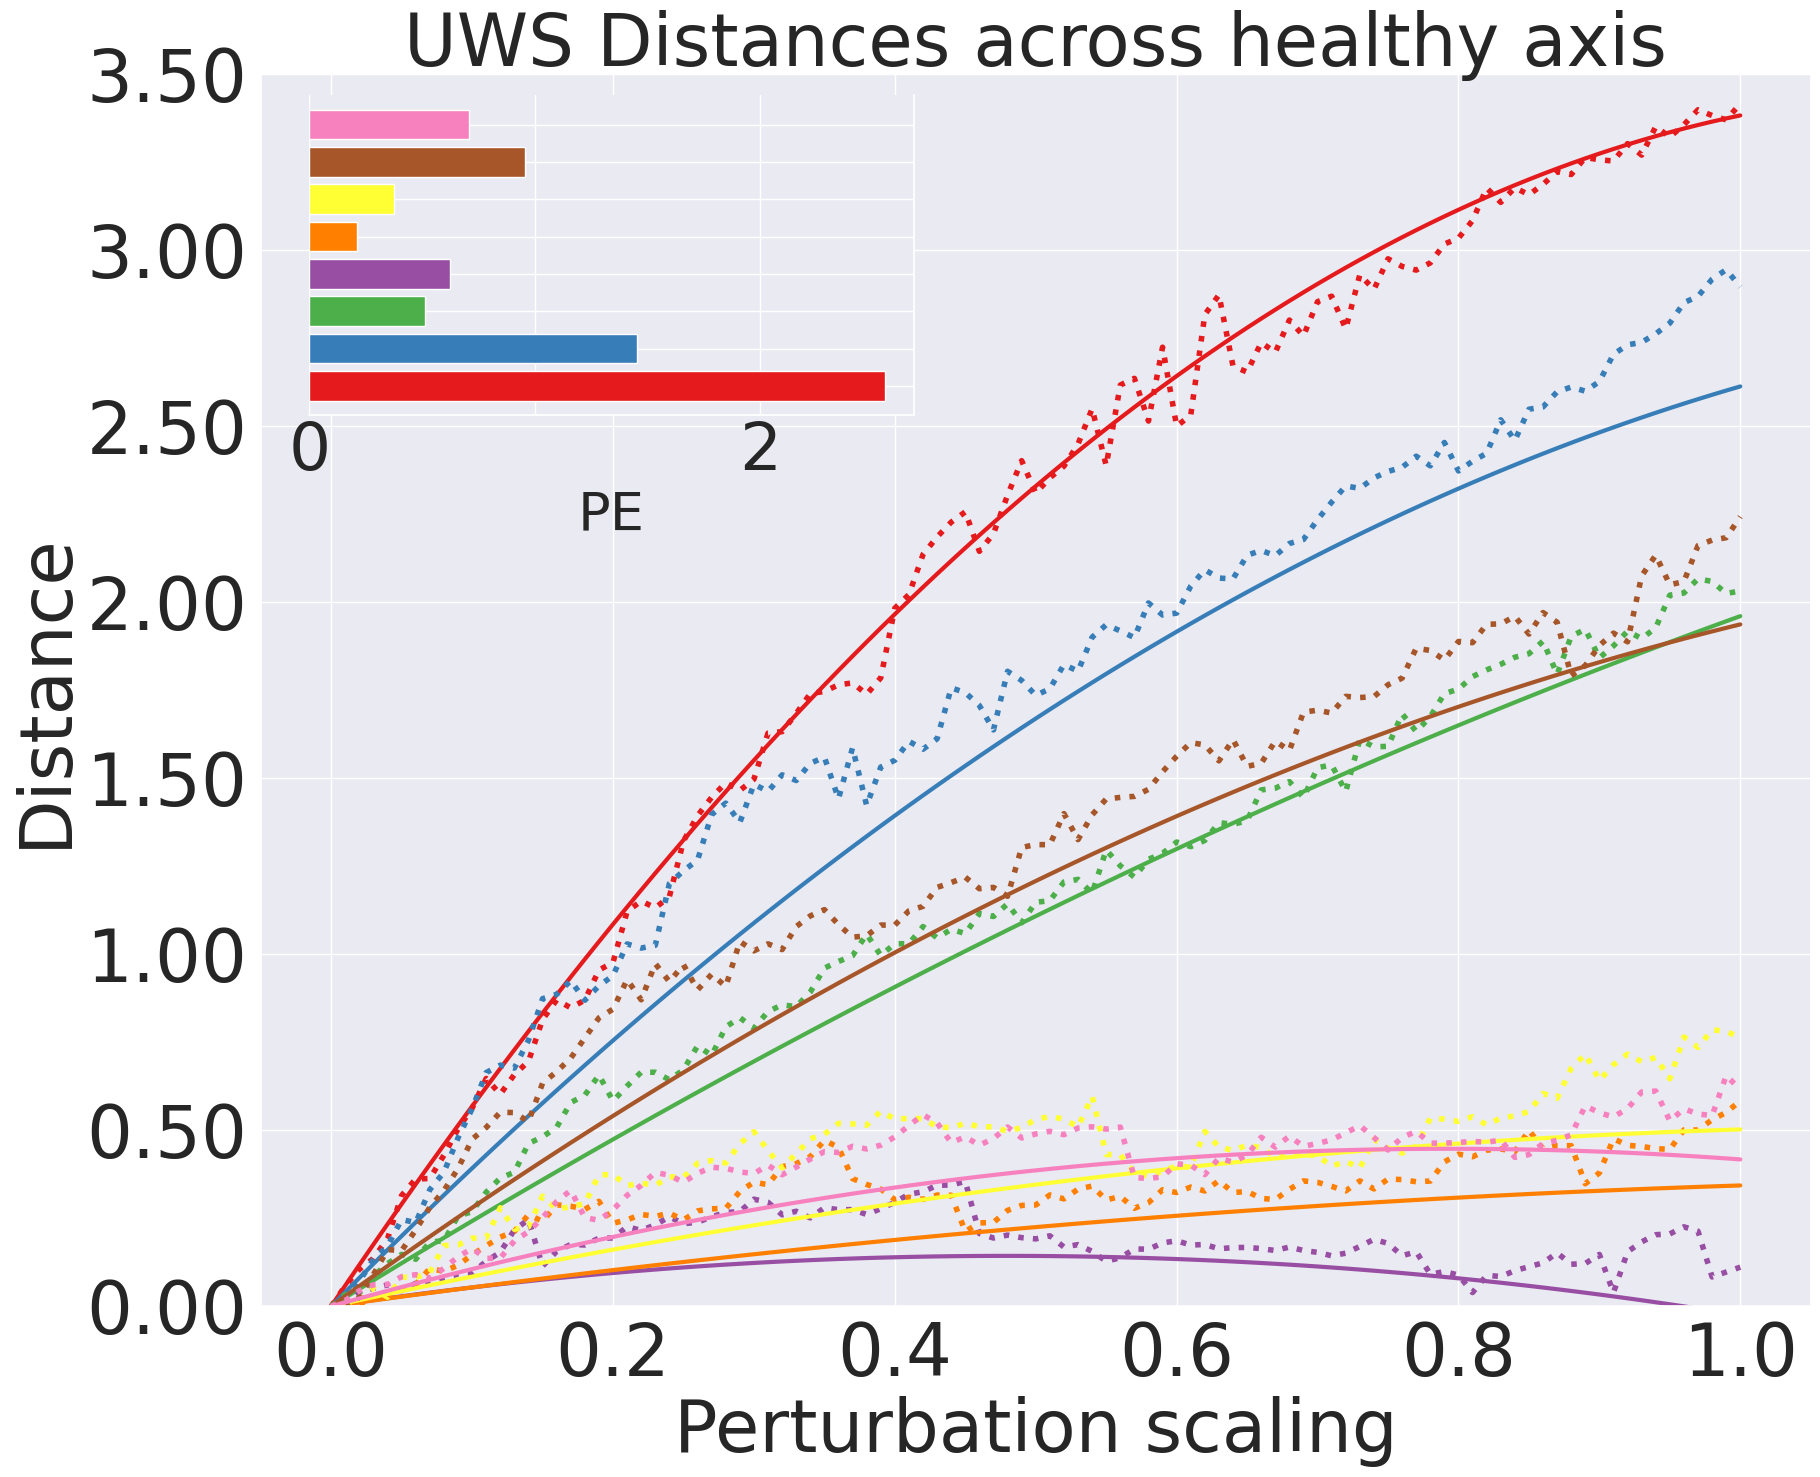

In [78]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,Bbox
def poly_func_3(x, a, b, c,d):
    return a * x**3 + b * x ** 2+ c * x + d  # You can adjust the degree of the polynomial
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c  # You can adjust the degree of the polynomial


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

UWS_speed_curves = list(map(lambda inst_speeds: np.cumsum([0]+inst_speeds), np.mean(UWS_velocities,axis=0)))
UWS_speed_curves = [np.insert(subarray, 0, 0) for subarray in UWS_speed_curves]
perturb_scale = np.arange(0.0,1.01,0.01)
quad_coefficients = []
coeff_fits_UWS = []
for idx,curve in enumerate(UWS_speed_curves):
    popt, _ = curve_fit(poly_func, perturb_scale, curve)
    coeff_fits_UWS.append(popt)
    fitted_curve = poly_func(perturb_scale, *popt)
    fitted_curve-=fitted_curve[0]
    plt.plot(perturb_scale, curve, color=condition_colors[idx], linewidth=4, linestyle='dotted')
    plt.plot(perturb_scale, fitted_curve, color=condition_colors[idx], linewidth=3)
    quad_coeff = -1*popt[0]  # Assuming the quadratic term is the first coefficient
    quad_coefficients.append(quad_coeff)

plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]
plt.title("UWS Distances across healthy axis",fontsize=font_size)
ax.tick_params(labelsize=18)
# Add the legends to the plot
plt.xlabel("Perturbation scaling", fontsize=font_size)
plt.ylabel("Distance", fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylim([0,3.5])

bbox = Bbox.from_bounds(0.01, -0.29, 1.3, 1.3)
axins = inset_axes(ax, width="30%", height="20%", loc='upper left', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
axins.barh(np.arange(len(quad_coefficients)), quad_coefficients, color=condition_colors)
axins.set_yticks(np.arange(len(quad_coefficients)))
#axins.set_yticklabels([f'Condition {i+1}' for i in range(len(quad_coefficients))])
axins.set_yticklabels([])
axins.set_xticklabels(['0','','2'])
axins.set_xlabel('PE', fontsize=39)
axins.spines['top'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.tick_params(axis='both', which='both', length=0)

#plt.legend(handles=plot_legend_handles, loc="upper left", fontsize=font_size-(font_size/5))
plt.savefig(f"plots/Figure5/UWS_DistanceWithScaling.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceWithScaling.png",bbox_inches = 'tight')

In [82]:
coeff_fits_MCS

[array([-2.80694463,  5.7984585 , -0.12809671]),
 array([-0.6828144 ,  3.40971102,  0.08139777]),
 array([-0.68258103,  2.55751196, -0.02428292]),
 array([0.2431865 , 0.0528872 , 0.09125677]),
 array([0.19161452, 0.43345559, 0.07108223]),
 array([0.09875131, 0.65579775, 0.11498271]),
 array([-0.58122974,  2.50508929,  0.13724641]),
 array([0.10707314, 0.58076245, 0.08458741])]

In [83]:
coeff_fits_UWS

[array([-2.55344799,  5.93648624, -0.02385788]),
 array([-1.45206374,  4.0652079 ,  0.16474563]),
 array([-0.51166465,  2.47226966,  0.07385413]),
 array([-0.6219276 ,  0.59669465,  0.08391515]),
 array([-0.21310551,  0.55627086,  0.10872819]),
 array([-0.37728308,  0.87960741,  0.12699575]),
 array([-0.95813891,  2.89527116,  0.15054458]),
 array([-0.7099043 ,  1.12707   ,  0.07340681])]

In [78]:
coeff_fits_MCS

[array([-1.43727185, -0.65103684,  4.94037844, -0.05837465]),
 array([ 2.14534317, -3.90082916,  4.6905238 , -0.02267283]),
 array([-1.77719591,  1.98321282,  1.49649048,  0.06192885]),
 array([ 2.45418487, -3.43809079,  1.51808463, -0.02779574]),
 array([ 0.3873617 , -0.38942804,  0.66471827,  0.05229131]),
 array([ 2.46598924, -3.60023256,  2.12804266, -0.00464243]),
 array([ 1.0257876 , -2.11991115,  3.11750502,  0.08748545]),
 array([ 2.26470379, -3.28998259,  1.93283596, -0.02527338])]

In [79]:
coeff_fits_UWS

[array([ 0.56788755, -3.40527931,  6.27552645, -0.0514061 ]),
 array([ 4.22582221, -7.79079704,  6.58810825, -0.040249  ]),
 array([ 1.79316651, -3.20141446,  3.54282595, -0.01313238]),
 array([ 2.37510728, -4.18458851,  2.0146812 , -0.0313013 ]),
 array([ 2.59925104, -4.11198209,  2.10807574, -0.01736148]),
 array([ 4.15299792, -6.60677994,  3.3590302 , -0.07446617]),
 array([ 2.64967567, -4.93265247,  4.47718055,  0.02200882]),
 array([ 2.52613419, -4.4991056 ,  2.63522265, -0.04913596])]

# Supplementary figures

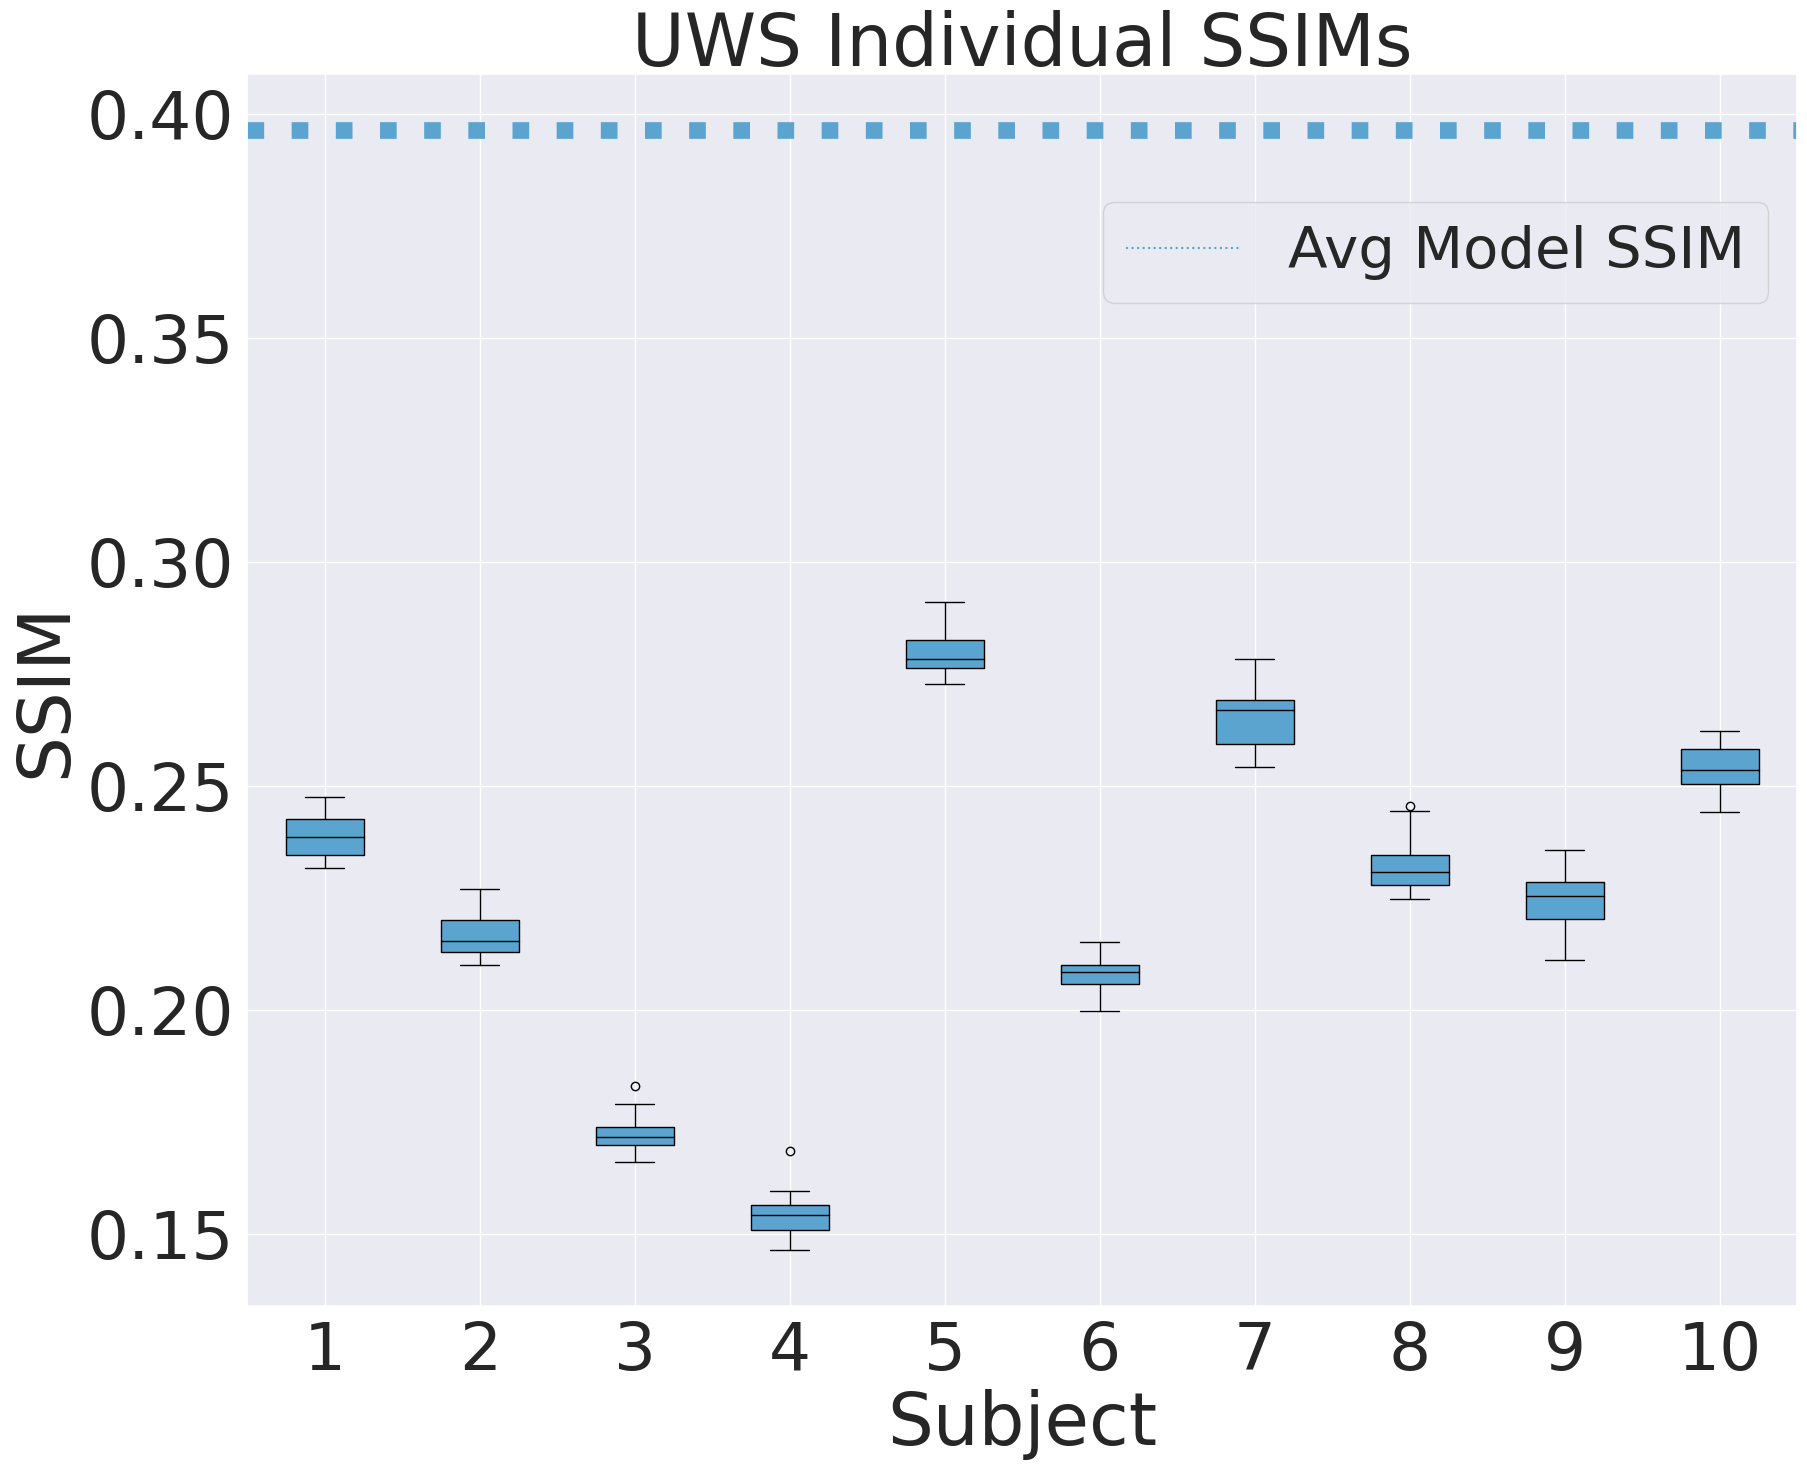

In [81]:
from scipy.io import loadmat
import os

UWS_Indv_Fit = loadmat(os.path.join(results_path, 'Individual_Fitting_UWS.mat'))
UWS_Gs, UWS_SSIMs =  UWS_Indv_Fit['indv_Gs_UWS'], UWS_Indv_Fit['indv_SSIMs_UWS']
mean_SSIM_UWS = optimal_df.groupby('condition')['SSIM'].mean()['UWS']

scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor
baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale
ax.boxplot(UWS_SSIMs.T, patch_artist=True, boxprops=dict(facecolor=baseline_colors[0]), medianprops=dict(color='black'))
# Add an dotted horizontal line with the corresponding baseline color for the mean 
plt.axhline(mean_SSIM_UWS, color=baseline_colors[0], linestyle='dotted', linewidth=12)
# And put a legend with the same dotted line
handle = plt.Line2D([0], [0], color=baseline_colors[0], linestyle='dotted', label='Avg Model SSIM', markersize=15)
plt.legend(handles=[handle], loc="upper right", fontsize=font_size-(font_size/5), bbox_to_anchor=(1.0,0.92))


ax.set_xlabel('Subject')
ax.set_ylabel('SSIM')
ax.set_title('UWS Individual SSIMs')
plt.savefig(f"plots/Supp/UWS_Indv_SSIMs.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Supp/UWS_Indv_SSIMs.png", bbox_inches='tight')

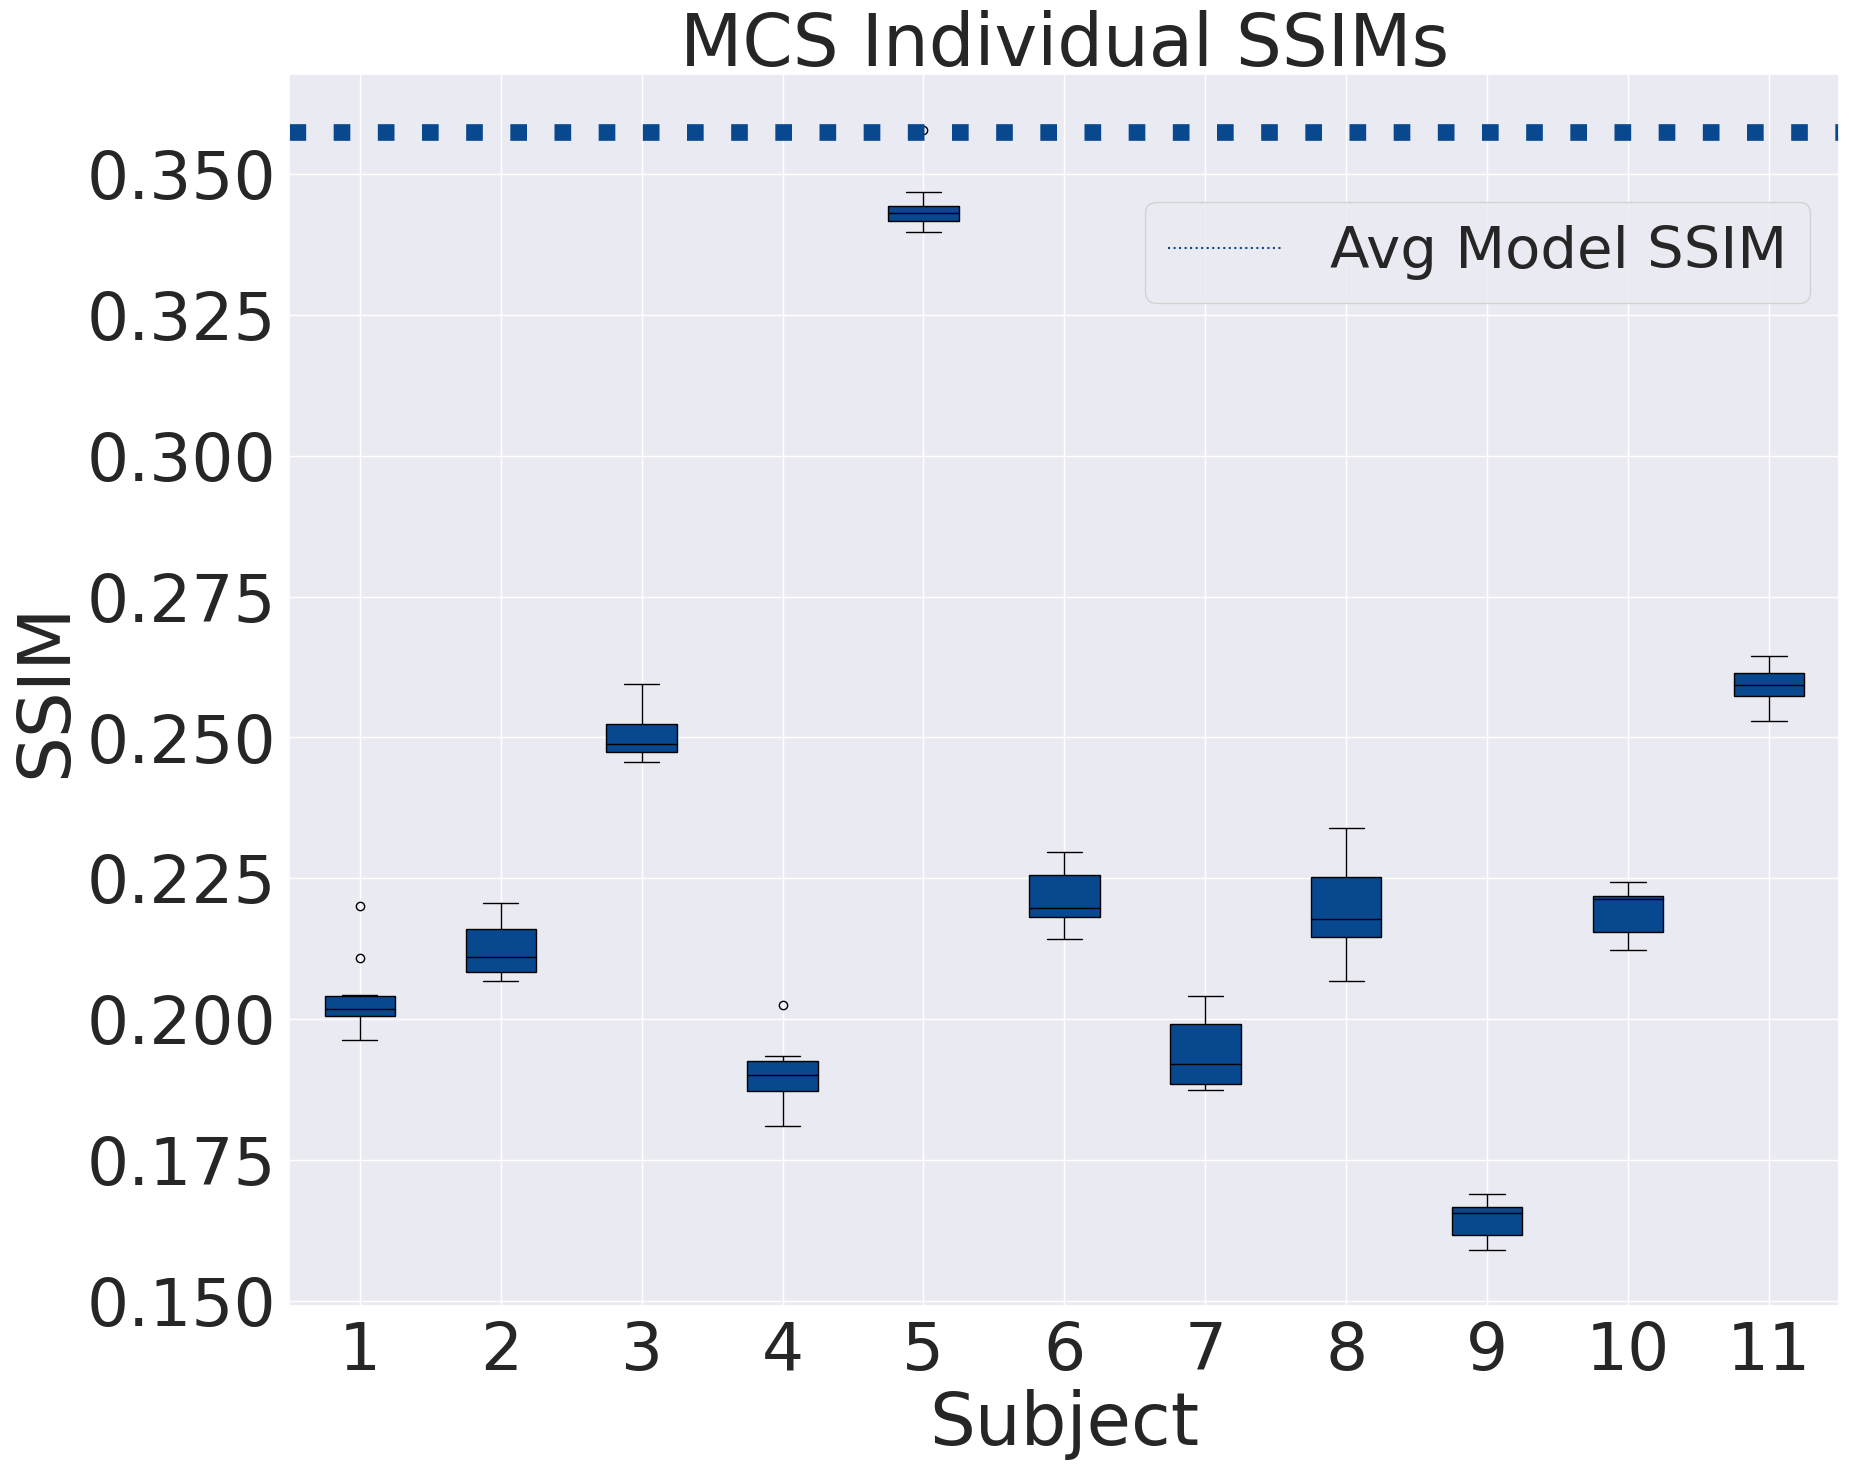

In [83]:
from scipy.io import loadmat
import os

MCS_Indv_Fit = loadmat(os.path.join(results_path, 'Individual_Fitting_MCS.mat'))
MCS_Gs, MCS_SSIMs =  MCS_Indv_Fit['indv_Gs_MCS'], MCS_Indv_Fit['indv_SSIMs_MCS']
mean_SSIM_MCS = optimal_df.groupby('condition')['SSIM'].mean()['MCS']


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor
baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale
ax.boxplot(MCS_SSIMs.T, patch_artist=True, boxprops=dict(facecolor=baseline_colors[1]), medianprops=dict(color='black'))
plt.axhline(mean_SSIM_MCS, color=baseline_colors[1], linestyle='dotted', linewidth=12)
# And put a legend with the same dotted line
handle = plt.Line2D([0], [0], color=baseline_colors[1], linestyle='dotted', label='Avg Model SSIM', markersize=15)
plt.legend(handles=[handle], loc="upper right", fontsize=font_size-(font_size/5), bbox_to_anchor=(1.0,0.92))
ax.set_xlabel('Subject')
ax.set_ylabel('SSIM')
ax.set_title('MCS Individual SSIMs')
plt.savefig(f"plots/Supp/MCS_Indv_SSIMs.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Supp/MCS_Indv_SSIMs.png", bbox_inches='tight')

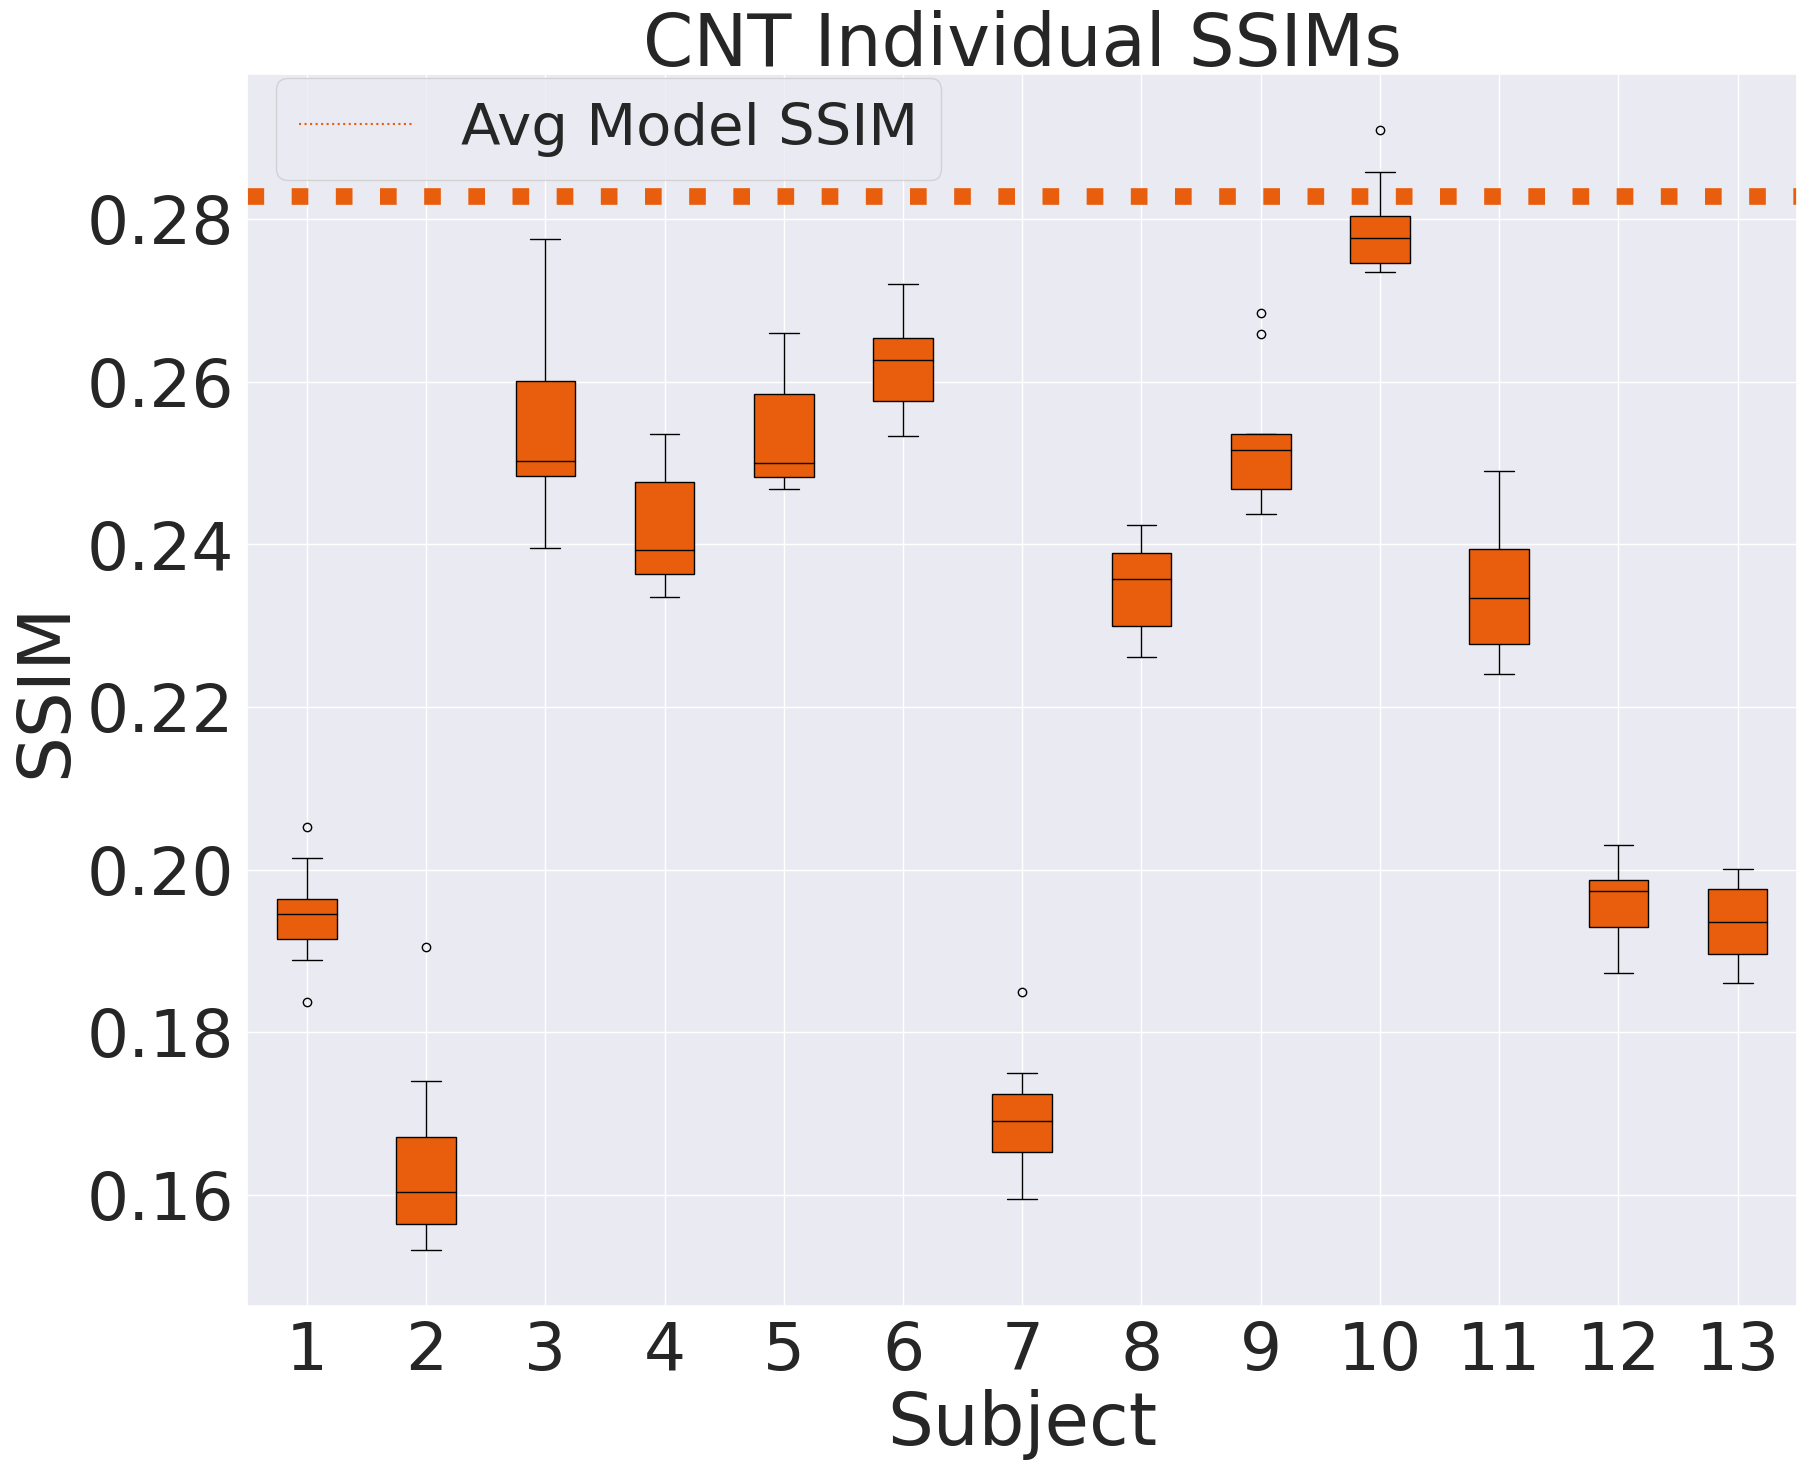

In [84]:
from scipy.io import loadmat
import os

CNT_Indv_Fit = loadmat(os.path.join(results_path, 'Individual_Fitting_CNT.mat'))
CNT_Gs, CNT_SSIMs =  CNT_Indv_Fit['indv_Gs_CNT'], CNT_Indv_Fit['indv_SSIMs_CNT']
mean_SSIM_CNT = optimal_df.groupby('condition')['SSIM'].mean()['CNT']


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor
baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale
ax.boxplot(CNT_SSIMs.T, patch_artist=True, boxprops=dict(facecolor=baseline_colors[2]), medianprops=dict(color='black'))
plt.axhline(mean_SSIM_CNT, color=baseline_colors[2], linestyle='dotted', linewidth=12)
# And put a legend with the same dotted line
handle = plt.Line2D([0], [0], color=baseline_colors[2], linestyle='dotted', label='Avg Model SSIM', markersize=30)
plt.legend(handles=[handle], loc="upper left", fontsize=font_size-(font_size/5), bbox_to_anchor=(0,1.02))
ax.set_xlabel('Subject')
ax.set_ylabel('SSIM')
ax.set_title('CNT Individual SSIMs')
plt.savefig(f"plots/Supp/CNT_Indv_SSIMs.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Supp/CNT_Indv_SSIMs.png", bbox_inches='tight')

## Spin null and CNT perturbation

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


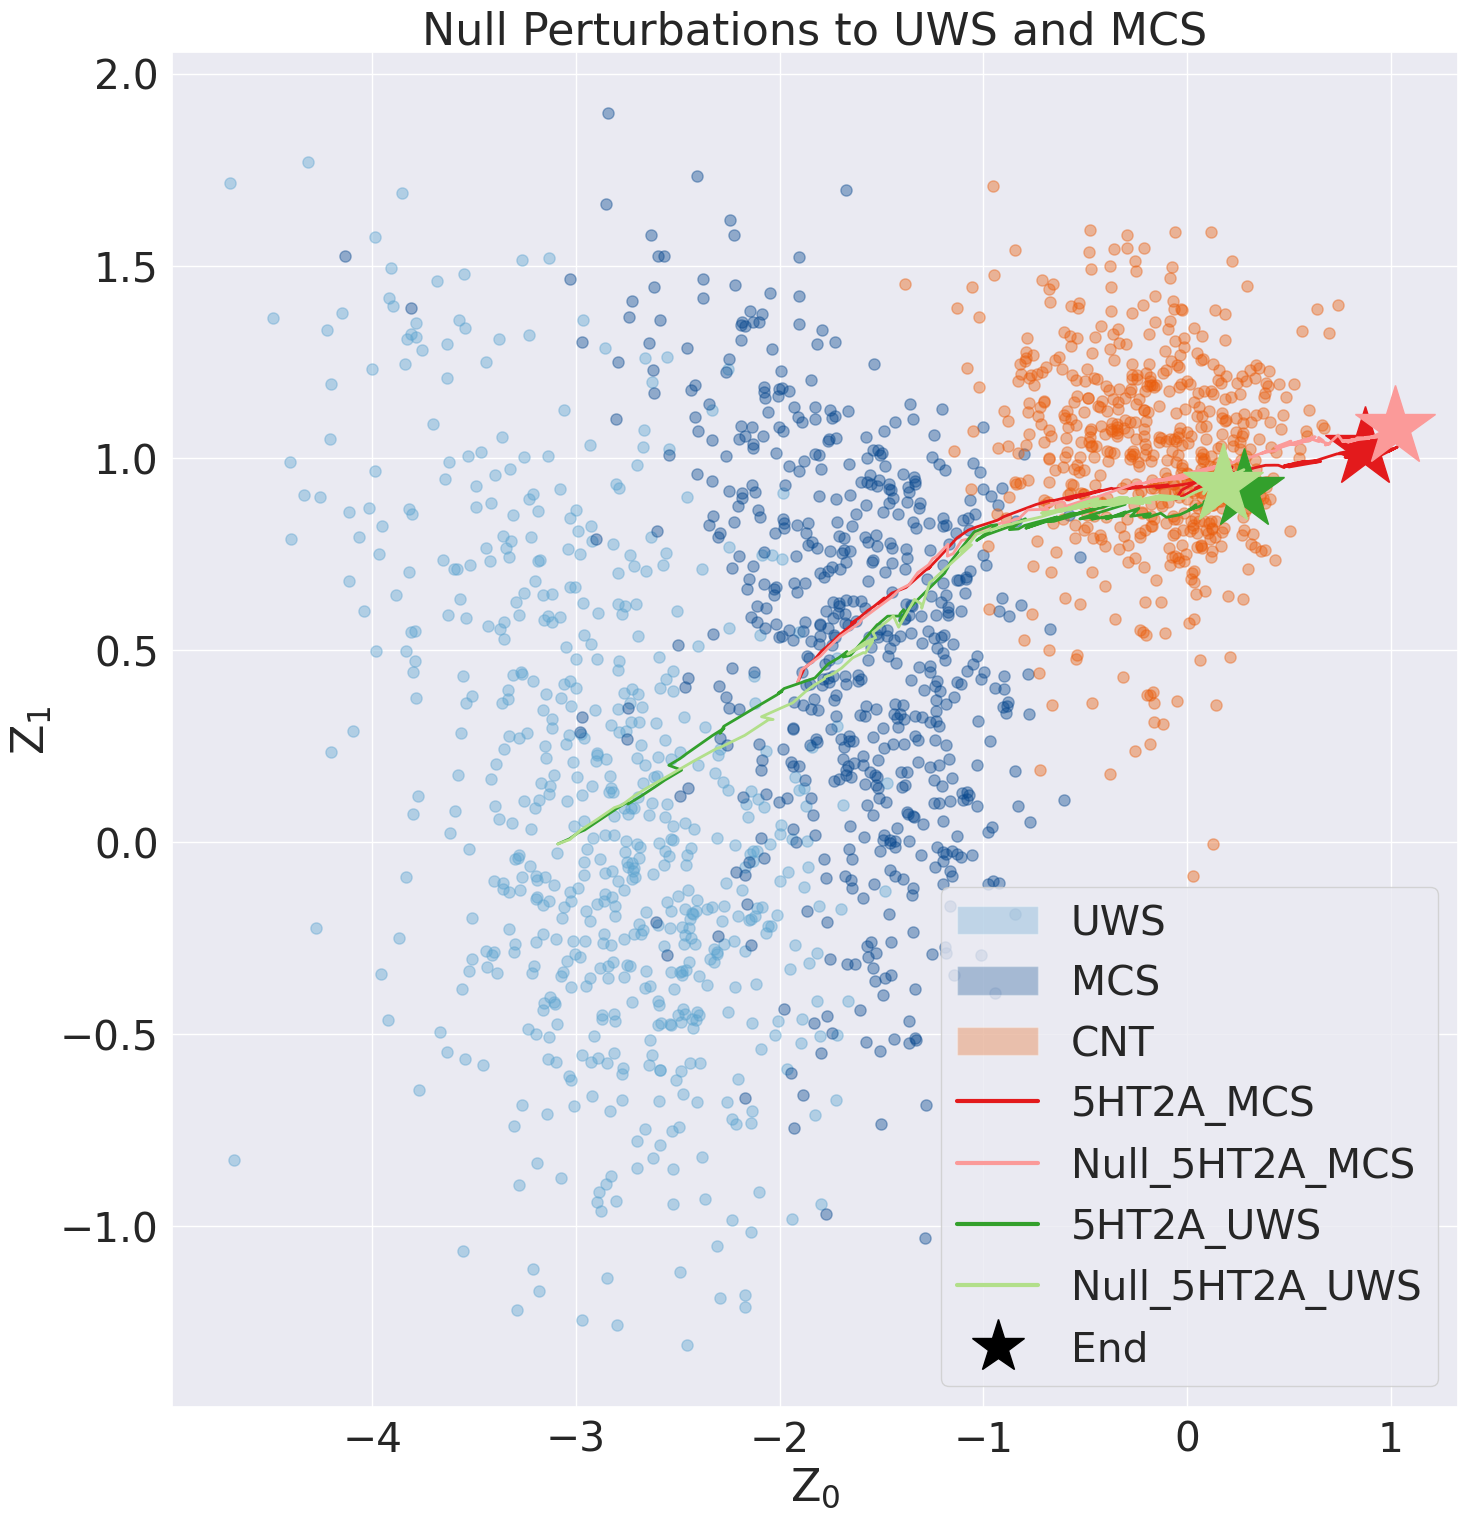

In [90]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 8.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale


models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

EXTRA_distances = []
EXTRA_maxidx = []
#CBDconditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'CB1', 'H3', 'MU','DAT']
conditions = ['5HT2A_MCS','Null_5HT2A_MCS', '5HT2A_UWS','Null_5HT2A_UWS']
condition_colors =sns.color_palette("Paired", n_colors=6)#len(conditions))  
condition_colors = condition_colors[2:][::-1]
EXTRA_velocities = [] 
for idx,cond in enumerate(conditions):
    perturb_fcs = np.mean(loadmat(f"{results_path}/FC_{cond}.mat")["FC_simul_all"], axis=0)
    perturb_fcs = perturb_fcs[:101]
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.zeros(shape=(101,))], batch_size=batch_size)
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=3)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=2)
    #plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=20)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [101])
    #savemat(os.path.join(base_cluster,"Results",f"UWS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
    EXTRA_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    EXTRA_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    EXTRA_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
#plt.xlim(XLIM[0], XLIM[1])
#plt.ylim(YLIM[0], YLIM[1])
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx], linewidth=3) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed


plt.title("Null Perturbations to UWS and MCS")
plt.savefig(f"plots/Supp/Null_Perturb_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Supp/Null_Perturb_ALL.png",bbox_inches = 'tight')
plt.show()


/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


t-statistic: 67.00, p-value: 0.1650
t-statistic: 100.00, p-value: 0.8695


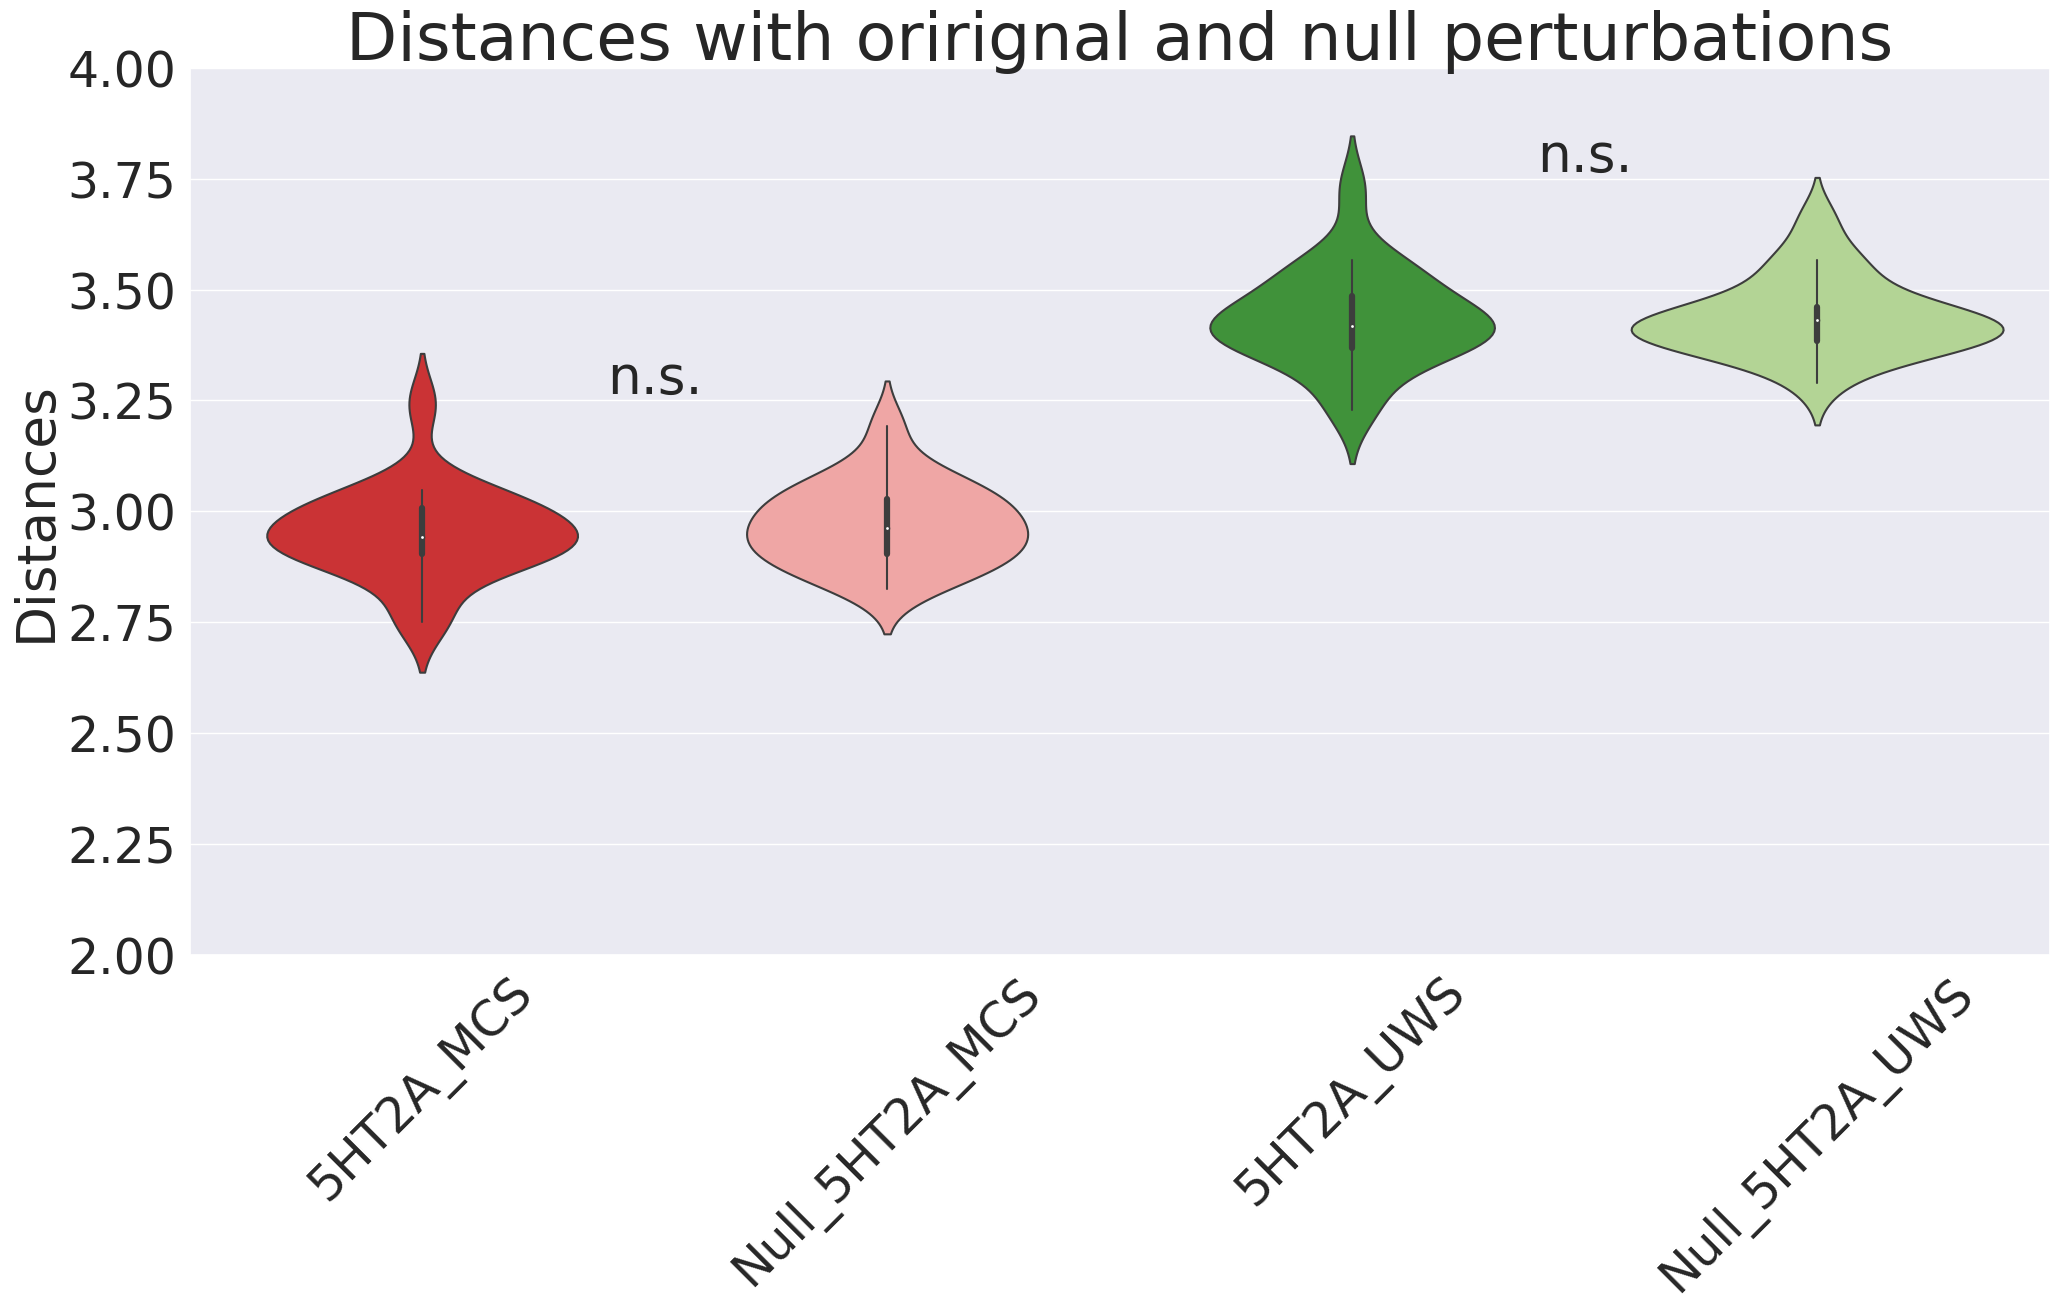

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import seaborn as sns
from scipy.io import loadmat

# Define the scaling factor
scaling_factor = 2.4
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 4.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

models = vae.get_layer('encoder'), vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1], baseline_colors[0], baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test, y_test_check], batch_size=batch_size)

cnt_centroid = np.mean(z_mean[y_test_check == 0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check == 1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check == 2], axis=0)
latent_centroids = np.array([uws_centroid, mcs_centroid, cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check == 1], z_mean[y_test_check == 2], z_mean[y_test_check == 0]])

BETA = np.arange(0, 1.01, 0.01)
# add the colorbar to the plo

conditions = ['5HT2A_MCS','Null_5HT2A_MCS', '5HT2A_UWS','Null_5HT2A_UWS']
condition_colors =sns.color_palette("Paired", n_colors=6)#len(conditions))  
condition_colors = condition_colors[2:][::-1]
# conditions = ['5HT2A', '5HT1A']
EXTRA2_distances = np.zeros((20, len(conditions)))
EXTRA2_maxidx = np.zeros((20, len(conditions)))
EXTRA2_velocities = np.zeros((20, len(conditions), 100))  # We dont take the velocity at time 0, so in total we have 100 points

for idx, cond in enumerate(conditions):
    perturb_fcs = loadmat(f"{results_path}/FC_{cond}.mat")["FC_simul_all"]
    for rep in range(20):
        perturb_fcs_rep = perturb_fcs[rep, :, :, :]  # Shape (rep, scale, nreg, nreg)
        z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs_rep, (101, 90 * 90)), np.ones(shape=(101,))], batch_size=batch_size)

        latent_dist = np.linalg.norm(z_perturb - cnt_centroid, axis=1)
        latent_dist = np.reshape(latent_dist, [101])
    
        EXTRA2_distances[rep, idx] = (np.max(np.linalg.norm(z_perturb - z_perturb[0], axis=1)))
        EXTRA2_maxidx[rep, idx] = (np.argmax(np.linalg.norm(z_perturb - z_perturb[0], axis=1)))
        EXTRA2_velocities[rep, idx, :] = calculate_distance_along_line(z_perturb[0, :], cnt_centroid, z_perturb)

data = EXTRA2_distances

# Create the violin plot
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.violinplot(data=data, palette=condition_colors, showmedians=True, widths=0.7, showextrema=False, ax=ax, orient='v')

from scipy.stats import wilcoxon
# Extract the distances for each condition
MCS_null = EXTRA2_distances[:, 1]
MCS_true = EXTRA2_distances[:, 0]
# Perform a paired t-test to see if the distances are significantly different
t_stat, p_val = wilcoxon(MCS_null, MCS_true)
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

# If the p-value is greater than 0.5 add a n.s annotation to the plot
if p_val > 0.05:
    plt.annotate('n.s.', xy=(0.25, 0.65), xycoords='axes fraction', fontsize=font_size, ha='center', va='center')

from scipy.stats import wilcoxon
# Extract the distances for each condition
UWS_null = EXTRA2_distances[:, 2]
UWS_true = EXTRA2_distances[:, 3]
# Perform a paired t-test to see if the distances are significantly different
t_stat, p_val = wilcoxon(UWS_null, UWS_true)
print(f"t-statistic: {t_stat:.2f}, p-value: {p_val:.4f}")

# If the p-value is greater than 0.5 add a n.s annotation to the plot
if p_val > 0.05:
    plt.annotate('n.s.', xy=(0.75, 0.9), xycoords='axes fraction', fontsize=font_size, ha='center', va='center')

# Set custom colors for each category
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(condition_colors[i])

# Customize the plot
plt.xticks(np.arange(len(conditions)), conditions, rotation=45)
plt.yticks()

plt.ylim([2, 4])
plt.ylabel('Distances')
plt.title('Distances with orirignal and null perturbations', fontsize=font_size*1.25)
plt.savefig(f"plots/Supp/Extra_Distances.svg", bbox_inches='tight')
plt.savefig(f"plots/Supp/Extra_Distances.png", bbox_inches='tight')
# Display the plot
plt.show()


/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


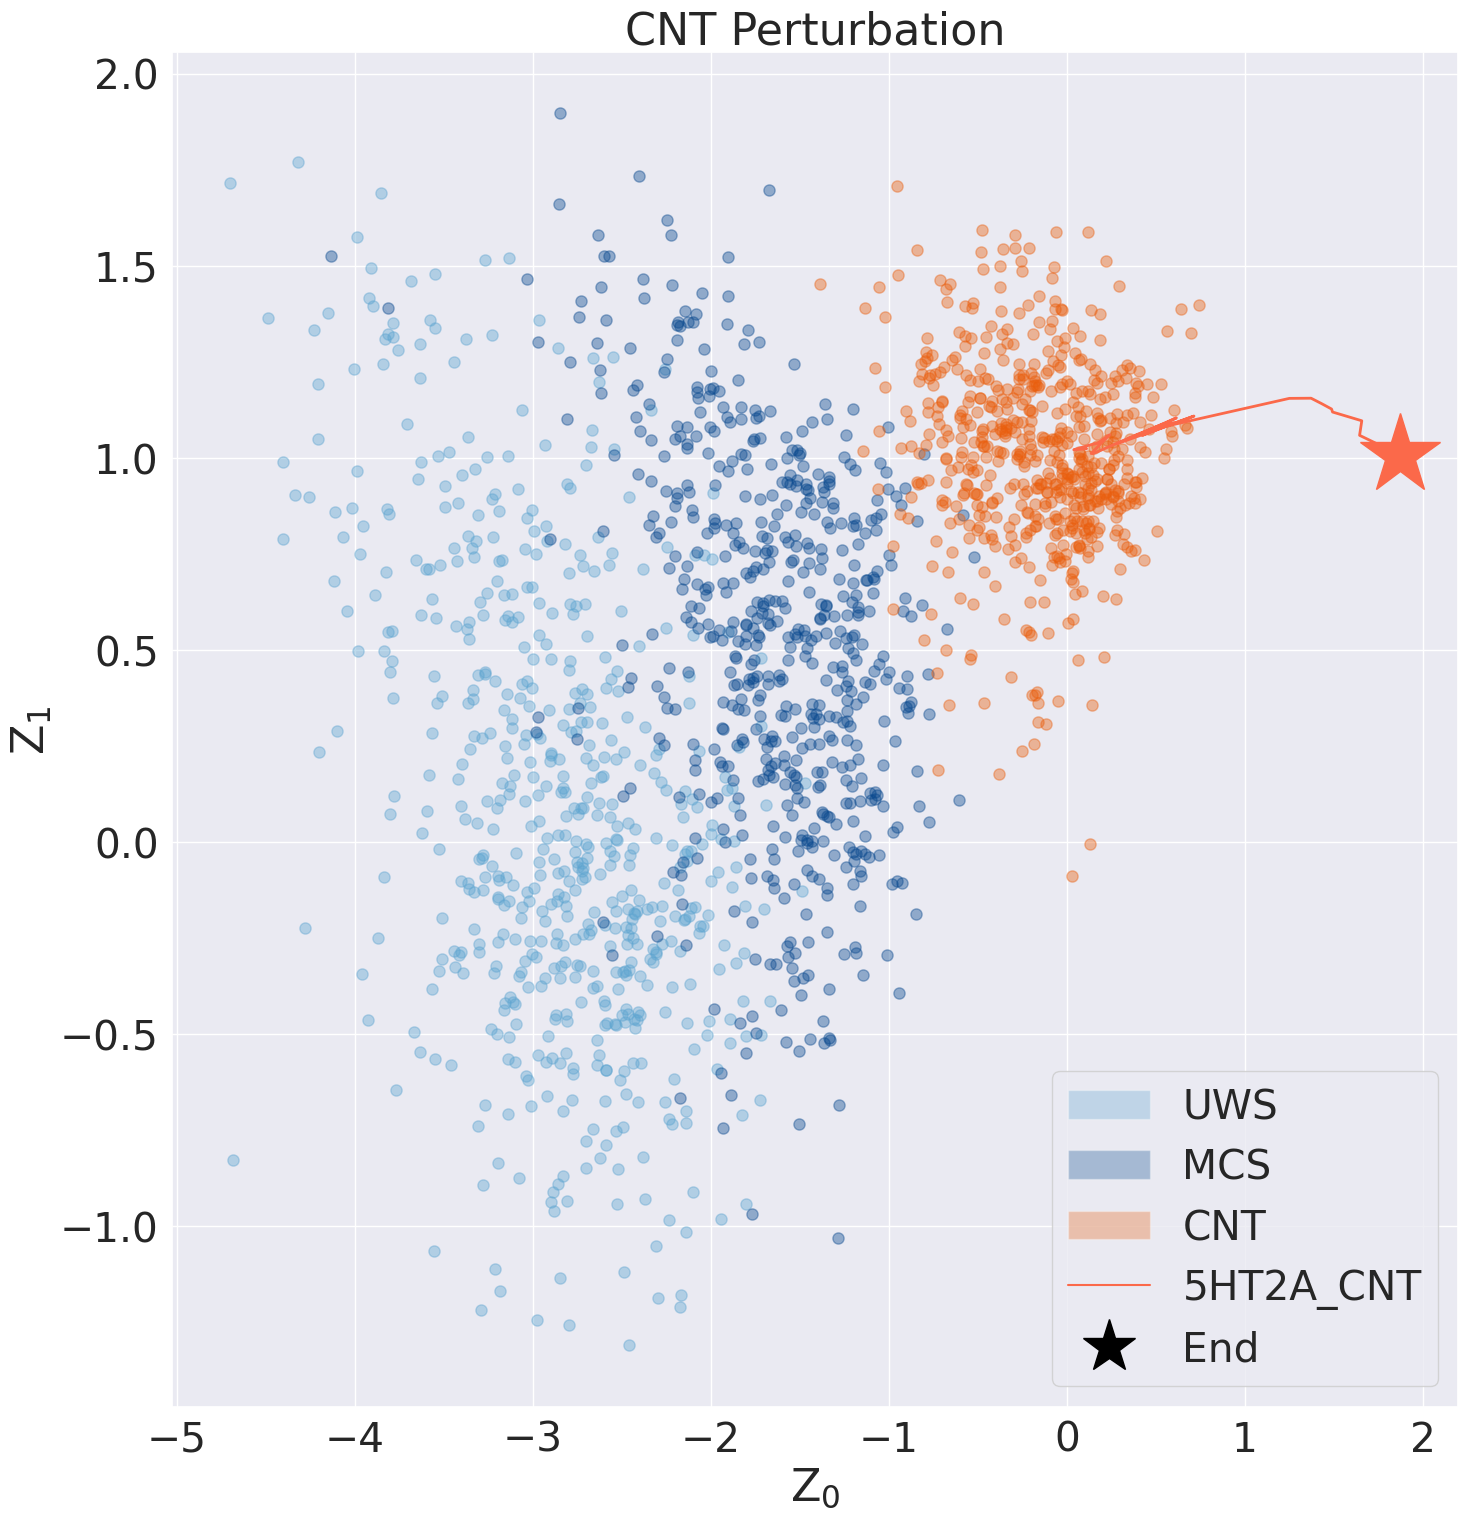

In [94]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 8.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale


models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=23)

baseline_colors = [sns.color_palette('Blues', n_colors=10)[5],sns.color_palette('Blues', n_colors=10)[9],sns.color_palette('Oranges', n_colors=2)[-1]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

EXTRA_distances = []
EXTRA_maxidx = []
#CBDconditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'CB1', 'H3', 'MU','DAT']
conditions = ['5HT2A_CNT']

condition_colors =sns.color_palette("Reds", n_colors=len(conditions))  
EXTRA_velocities = [] 
for idx,cond in enumerate(conditions):
    perturb_fcs = np.mean(loadmat(f"{results_path}/FC_{cond}.mat")["FC_simul_all"], axis=0)
    # After this point trajectory enters a loop
    perturb_fcs = perturb_fcs[:23]
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(23,90*90)),np.zeros(shape=(23,))], batch_size=batch_size)
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=2)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=2)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [23])
    #savemat(os.path.join(base_cluster,"Results",f"UWS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
    EXTRA_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    EXTRA_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    EXTRA_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
#plt.xlim(XLIM[0], XLIM[1])
#plt.ylim(YLIM[0], YLIM[1])
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed


plt.title("CNT Perturbation")
plt.savefig(f"plots/Supp/CNT_Perturb_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Supp/CNT_Perturb_ALL.png",bbox_inches = 'tight')
plt.show()
